# First Install Dependencies

In [75]:
!pip install scikit-learn
!pip install pandas
!pip install matplotlib
!pip install seaborn
!pip install xgboost
!pip install holidays
!pip install datetime
!pip install statsmodels
!pip install plotly

--------------------------------------------------------------------------------
# Problem Statement

Before diving into the code, it is important to outline the goal of this notebook. The objective is to clean and preprocess the 2013 flight dataset, handle missing data, and prepare it for further analysis and modeling. Specifically, we will:

- Identify and handle missing values.

- Remove duplicate rows.

- Validate data integrity (e.g., check for invalid values).

- Impute missing values using appropriate techniques.

- Create new features (e.g., flight_status) to categorize flights.

# Loading the Dataset & Checking for Missing Values

The first step is to load the dataset into a Pandas DataFrame. This allows us to perform exploratory data analysis (EDA) and data cleaning operations.

Missing data can significantly impact the quality of analysis and modeling. Here, we calculate the number and percentage of missing values in each column to identify which columns require attention.

In [ ]:
from sklearn.impute import KNNImputer
import pandas as pd
df = pd.read_csv("flights.csv")

import pandas as pd

missing_values = df.isnull().sum()

missing_percentage = (missing_values / len(df)) * 100

print("Missing Values:\n", missing_values)
print("\nMissing Values (%):\n", missing_percentage)

Missing Values:
 id                   0
year                 0
month                0
day                  0
dep_time          8255
sched_dep_time       0
dep_delay         8255
arr_time          8713
sched_arr_time       0
arr_delay         9430
carrier              0
flight               0
tailnum           2512
origin               0
dest                 0
air_time          9430
distance             0
hour                 0
minute               0
time_hour            0
name                 0
dtype: int64

Missing Values (%):
 id                0.000000
year              0.000000
month             0.000000
day               0.000000
dep_time          2.451184
sched_dep_time    0.000000
dep_delay         2.451184
arr_time          2.587180
sched_arr_time    0.000000
arr_delay         2.800081
carrier           0.000000
flight            0.000000
tailnum           0.745896
origin            0.000000
dest              0.000000
air_time          2.800081
distance          0.000000
hour  

# Checking for Duplicate Rows
Duplicate rows can skew analysis and modeling results. Here, we check for and remove any duplicate rows in the dataset.

In [ ]:
duplicates = df.duplicated().sum()

print("Number of duplicate rows:", duplicates)

df = df.drop_duplicates()

Number of duplicate rows: 0


# Validating Data Integrity

To ensure the dataset is clean, we check for invalid or unexpected values in categorical and numerical columns. For example:

Are there negative values in dep_time or distance?

Are there unexpected categories in tailnum or carrier?

In [ ]:
print("Unique values in 'tailnum':", df['tailnum'].unique())
print("Unique values in 'carrier':", df['carrier'].unique())

print("Invalid 'dep_time' values:", df[df['dep_time'] < 0]['dep_time'].unique())
print("Invalid 'distance' values:", df[df['distance'] < 0]['distance'].unique())

Unique values in 'tailnum': ['N14228' 'N24211' 'N619AA' ... 'N776SK' 'N785SK' 'N557AS']
Unique values in 'carrier': ['UA' 'AA' 'B6' 'DL' 'EV' 'MQ' 'US' 'WN' 'VX' 'FL' 'AS' '9E' 'F9' 'HA'
 'YV' 'OO']
Invalid 'dep_time' values: []
Invalid 'distance' values: []


# Identifying Rows with Multiple Missing Attributes

Some rows may have multiple missing attributes, which could indicate data quality issues. Here, we identify and inspect these rows.

In [ ]:
import pandas as pd

df['missing_count'] = df.isnull().sum(axis=1)

rows_with_multiple_missing = df[df['missing_count'] >= 2]

print("Rows with multiple missing attributes:")
print(rows_with_multiple_missing)

Rows with multiple missing attributes:
            id  year  month  day  dep_time  sched_dep_time  dep_delay  \
471        471  2013      1    1    1525.0            1530       -5.0   
477        477  2013      1    1    1528.0            1459       29.0   
615        615  2013      1    1    1740.0            1745       -5.0   
643        643  2013      1    1    1807.0            1738       29.0   
725        725  2013      1    1    1939.0            1840       59.0   
...        ...   ...    ...  ...       ...             ...        ...   
336771  336771  2013      9   30       NaN            1455        NaN   
336772  336772  2013      9   30       NaN            2200        NaN   
336773  336773  2013      9   30       NaN            1210        NaN   
336774  336774  2013      9   30       NaN            1159        NaN   
336775  336775  2013      9   30       NaN             840        NaN   

        arr_time  sched_arr_time  arr_delay  ... tailnum  origin dest  \
471       1

# Creating the flight_status Column

To better understand flight outcomes, we categorize flights into three statuses:

Completed: Flights with both departure and arrival times recorded.

Incomplete: Flights with a departure time but no arrival time.

Cancelled: Flights with no departure time.

In [ ]:
import pandas as pd
import numpy as np

# Flight is cancelled is dep time is null and incompelte when arrival time is null, otherwise completed
df['flight_status'] = np.where(
    df['dep_time'].isnull(), 'cancelled', 
    np.where(
        df['arr_time'].isnull(), 'incomplete',  
        'completed'  
    )
)

print(df['flight_status'].value_counts())


flight_status
completed     328063
cancelled       8255
incomplete       458
Name: count, dtype: int64


In [ ]:
df['tailnum'].fillna('private', inplace=True)

print(df['tailnum'].value_counts())

tailnum
private    2512
N725MQ      575
N722MQ      513
N723MQ      507
N711MQ      486
           ... 
N7ASAA        1
N932DN        1
N318AS        1
N651UA        1
N557AS        1
Name: count, Length: 4044, dtype: int64


C:\Users\Eric\AppData\Local\Temp\ipykernel_4736\373628596.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['tailnum'].fillna('private', inplace=True)


# Cleaning and Imputing Numerical Columns
For numerical columns like dep_delay, arr_delay, and air_time, we:

Replace non-standard missing values (e.g., -999, 'NA') with NaN.

Convert columns to numeric types.

Fill missing values in completed flights with 0.

Use a KNN Imputer to estimate missing air_time values based on related features.

In [ ]:
import pandas as pd
import numpy as np

df_cleaned = df.copy(deep=True)

df_cleaned.replace([-999, 'NA', ''], np.nan, inplace=True)

# Numerical columns
numerical_columns = ['dep_delay', 'arr_delay', 'air_time', 'dep_time', 'arr_time']

# Convert columns to numeric value
df_cleaned[numerical_columns] = df_cleaned[numerical_columns].apply(pd.to_numeric, errors='coerce')

# Fill missing tailnum values private
df_cleaned['tailnum'] = df_cleaned['tailnum'].fillna('private')

# Replace NaNs with 0 values for completed flights
for col in numerical_columns:
    df_cleaned.loc[df_cleaned['flight_status'] == 'completed', col] = (
        df_cleaned.loc[df_cleaned['flight_status'] == 'completed', col].fillna(0)
    )

# Fill other flight status with NaN's as 0
df_cleaned[numerical_columns] = df_cleaned[numerical_columns].fillna(0)

missing_rows = df_cleaned[df_cleaned.isnull().any(axis=1)]
if not missing_rows.empty:
    print("Rows with remaining missing values:")
    print(missing_rows)
else:
    print("No remaining missing values in the dataset.")

print("\nMissing values after replacement:")
print(df_cleaned[numerical_columns].isnull().sum())

print("\nNumerical Columns after replacement:")
print(df_cleaned[numerical_columns].describe())


No remaining missing values in the dataset.

Missing values after replacement:
dep_delay    0
arr_delay    0
air_time     0
dep_time     0
arr_time     0
dtype: int64

Numerical Columns after replacement:
           dep_delay      arr_delay       air_time       dep_time  \
count  336776.000000  336776.000000  336776.000000  336776.000000   
mean       12.329263       6.702301     146.467118    1316.040778   
std        39.762251      44.018670      95.654155     525.447907   
min       -43.000000     -86.000000       0.000000       0.000000   
25%        -5.000000     -16.000000      78.000000     854.000000   
50%        -1.000000      -4.000000     126.000000    1349.000000   
75%        10.000000      13.000000     188.000000    1737.000000   
max      1301.000000    1272.000000     695.000000    2400.000000   

            arr_time  
count  336776.000000  
mean     1463.194138  
std       577.818818  
min         0.000000  
25%      1047.000000  
50%      1518.000000  
75%      193

# Calculate Air Time for Zero Values

For any zero values of air_time (where air_time was originally NaN), attempt to calculate the air time using the formula `arrival time - departure time`.

Only apply this change if there are arrival times and departure times that can be used (non-zero values).

Finally, if some rows have larger depature times than the arrival time, ensure there are no negative values.

In [ ]:
# Completed flight rows only
completed_flights = df_cleaned[df_cleaned['flight_status'] == 'completed']

# Air Time of 0 count
zero_air_time_count = completed_flights[completed_flights['air_time'] == 0].shape[0]

# Print
print(f"Number of 'completed' flights with air_time = 0: {zero_air_time_count}")

Number of 'completed' flights with air_time = 0: 717


# Impute Air Time for Remaining Zero Values

Any remaining zero values for air time resulted from the departure time being larger than the arrival time.

For these values, we must impute them using a KNN Imputer.

In [ ]:
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
import numpy as np

# Completed flight rows only
completed_flights = df_cleaned[df_cleaned['flight_status'] == 'completed']

# Separate rows where air_time = 0 and air_time > 0 
flights_to_impute = completed_flights[completed_flights['air_time'] == 0]
flights_with_air_time = completed_flights[completed_flights['air_time'] > 0]

#distance, dep_time, arr_time, dep_delay, arr_delay
features = ['distance', 'dep_time', 'arr_time', 'dep_delay', 'arr_delay']

X_train = flights_with_air_time[features] 
y_train = flights_with_air_time['air_time']  
X_impute = flights_to_impute[features]  

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_impute_scaled = scaler.transform(X_impute)

imputer = KNNImputer(n_neighbors=5)

# Fit the imputer on the training data
imputer.fit(X_train_scaled)

# Impute air_time for rows with air_time = 0
imputed_data = imputer.transform(X_impute_scaled)

# Replace air_time = 0 with the imputed values
df_cleaned.loc[flights_to_impute.index, 'air_time'] = imputed_data[:, -1] 

# Remove airtimes lower than 0
df_cleaned = df_cleaned[(df_cleaned['air_time'] > 0)]

print("\nNumber of 'completed' flights with air_time = 0 after imputation:",
      df_cleaned[(df_cleaned['flight_status'] == 'completed') & (df_cleaned['air_time'] == 0)].shape[0])


Number of 'completed' flights with air_time = 0 after imputation: 0


In [10]:
print(df_cleaned[df_cleaned['flight_status'] == 'completed']['air_time'].describe())

count    327346.000000
mean        150.686460
std          93.688305
min          20.000000
25%          82.000000
50%         129.000000
75%         192.000000
max         695.000000
Name: air_time, dtype: float64


# Finalizing the Dataset
After cleaning and imputing, we combine all flight statuses (completed, incomplete, cancelled) into a single dataset. We also create a new feature, total_delay, which sums dep_delay and arr_delay.

In [ ]:
import os

# Verify the final dataset
print("\nFinal Dataset Shape:", df_cleaned.shape)
print("\nFlight Status Distribution in Final Dataset:")
print(df_cleaned['flight_status'].value_counts())

# Add total delay time, and delay status
df_cleaned['total_delay'] = df_cleaned['dep_delay'] + df_cleaned['arr_delay']

# Check for missing values in the final dataset
print("\nMissing values in the final dataset:")
print(df_cleaned.isnull().sum())

# Save the final dataset to a CSV file only if it does not already exist
file_path = 'flights_EDA.csv'
if not os.path.exists(file_path):
    df_cleaned.to_csv(file_path, index=False)
    print("\nThe dataset has been saved as 'flights_EDA.csv'.")
else:
    print("\nThe file 'flights_EDA.csv' already exists. No new file was created.")


Final Dataset Shape: (327346, 23)

Flight Status Distribution in Final Dataset:
flight_status
completed    327346
Name: count, dtype: int64

Missing values in the final dataset:
id                0
year              0
month             0
day               0
dep_time          0
sched_dep_time    0
dep_delay         0
arr_time          0
sched_arr_time    0
arr_delay         0
carrier           0
flight            0
tailnum           0
origin            0
dest              0
air_time          0
distance          0
hour              0
minute            0
time_hour         0
name              0
missing_count     0
flight_status     0
total_delay       0
dtype: int64

The file 'flights_EDA.csv' already exists. No new file was created.


In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('flights_EDA.csv')

sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))

print("Dataset Overview:")
print(df.info())
print("\nSummary Statistics:")
print(df.describe())

print("\nFlight Status Distribution:")
print(df['flight_status'].value_counts())

Dataset Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 327346 entries, 0 to 327345
Data columns (total 29 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   id                 327346 non-null  int64  
 1   year               327346 non-null  int64  
 2   month              327346 non-null  int64  
 3   day                327346 non-null  int64  
 4   dep_time           327346 non-null  float64
 5   sched_dep_time     327346 non-null  int64  
 6   dep_delay          327346 non-null  float64
 7   arr_time           327346 non-null  float64
 8   sched_arr_time     327346 non-null  int64  
 9   arr_delay          327346 non-null  float64
 10  carrier            327346 non-null  object 
 11  flight             327346 non-null  int64  
 12  tailnum            327346 non-null  object 
 13  origin             327346 non-null  object 
 14  dest               327346 non-null  object 
 15  air_time           327346 non-nul

<Figure size 1200x600 with 0 Axes>

In [13]:
missing_values = df.isnull().sum()
print("Missing Values:\n", missing_values)

Missing Values:
 id                   0
year                 0
month                0
day                  0
dep_time             0
sched_dep_time       0
dep_delay            0
arr_time             0
sched_arr_time       0
arr_delay            0
carrier              0
flight               0
tailnum              0
origin               0
dest                 0
air_time             0
distance             0
hour                 0
minute               0
time_hour            0
name                 0
missing_count        0
flight_status        0
total_delay          0
date                 0
is_holiday           0
season               0
dep_time_category    0
arr_time_category    0
dtype: int64


# 12. Summary

The cleaned dataset is now ready for further analysis and modeling. Key steps included:

- Handling missing values.

- Removing duplicates.

- Validating data integrity.

- Imputing missing air_time values.

- Creating new features like flight_status and total_delay.

- The cleaned dataset is saved as `flights_EDA.csv`.

We will now move onto `EDA_Analysis.ipynb` to continue with our exploratory data analysis on the clean data, check for outliers, trends, and patterns in the data. Thank you.


# Exploratory Data Analysis

The objective of EDA is to analyze patterns and trends on what contributes to delayed flights such as whether winter effects effects delays which can be analyzed with month, air congestion which which can be analyzed departure time of the flight, etc. We aim to investigate factors such as seasonal effects (e.g., winter weather), air congestion (e.g., departure time), and carrier performance. This analysis will help us identify key drivers of delays and prepare the data for further modeling.

--------------------------------------------------------------------------------
# Understanding the Data

We can plot each of the features distributions to better understand the data.

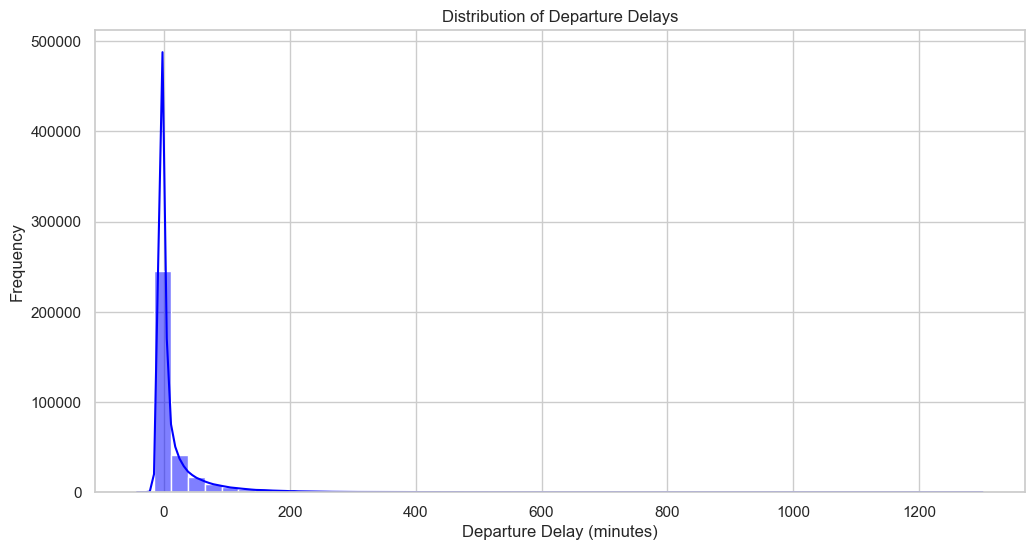

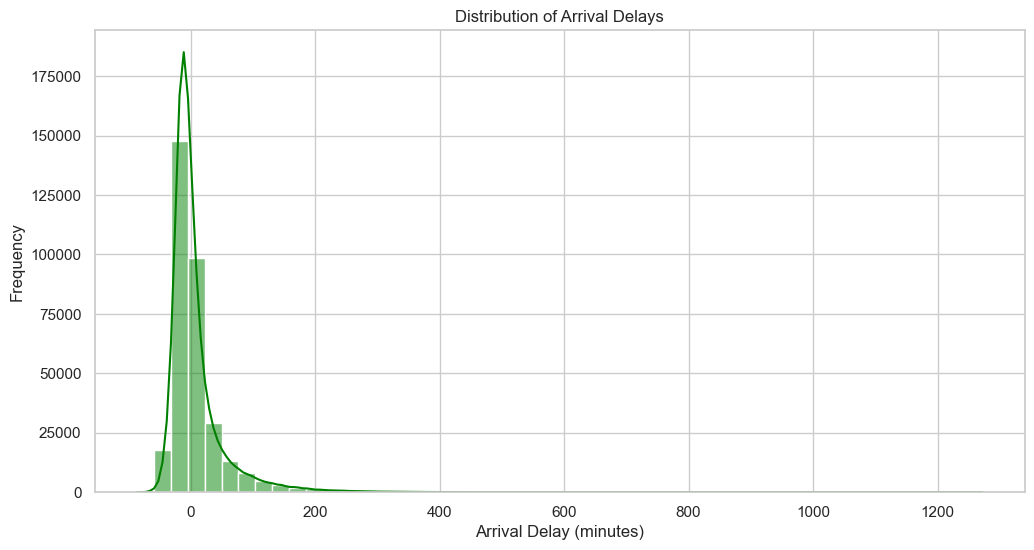

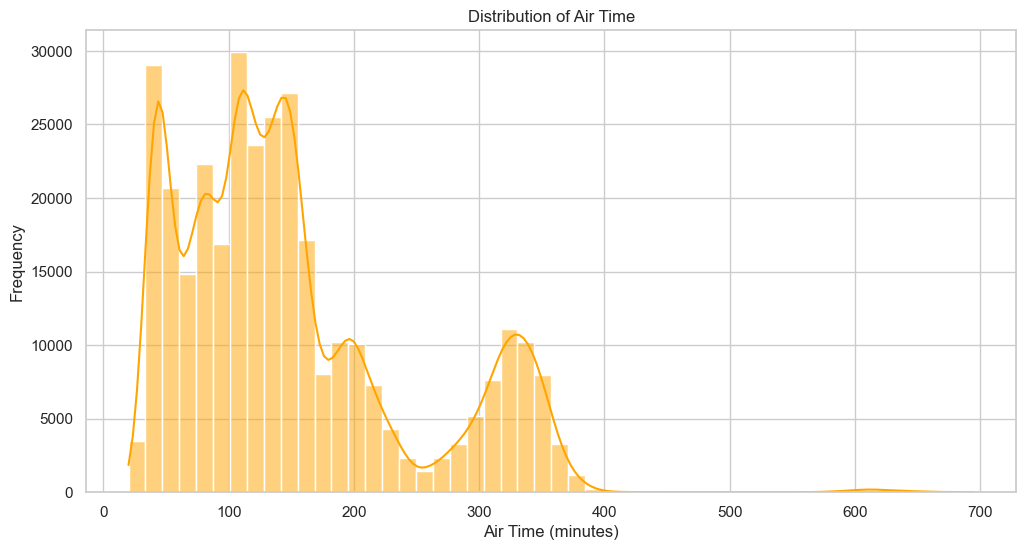

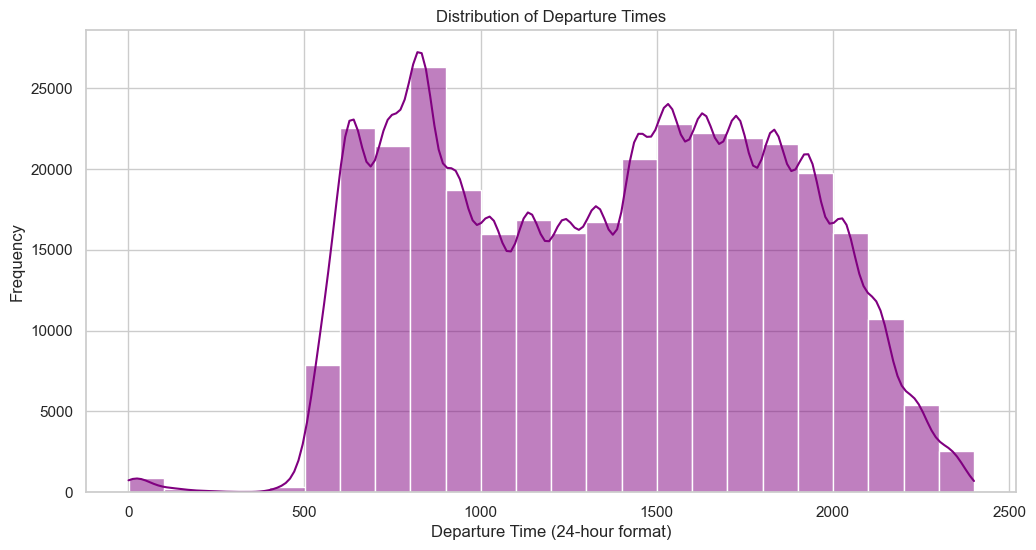

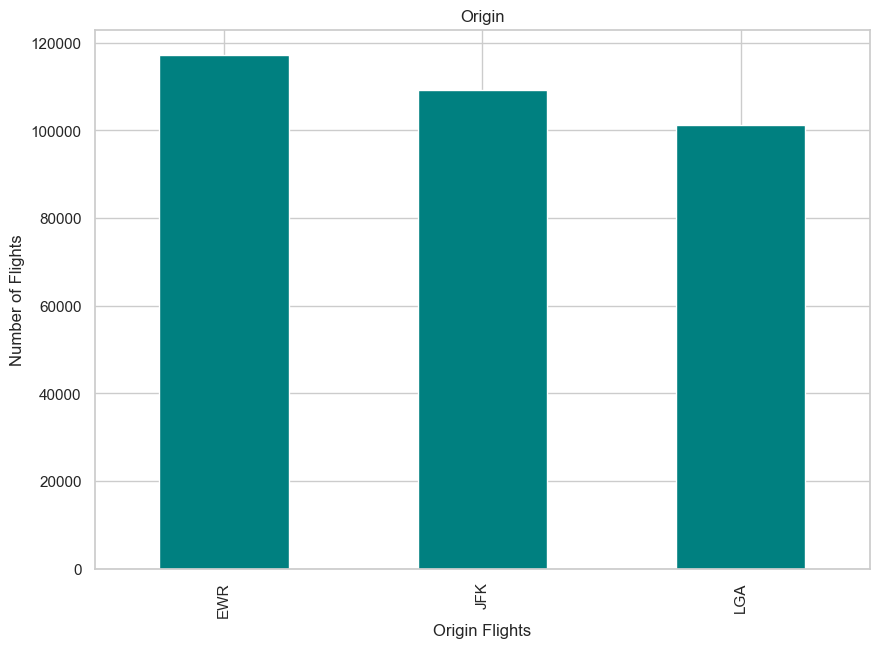

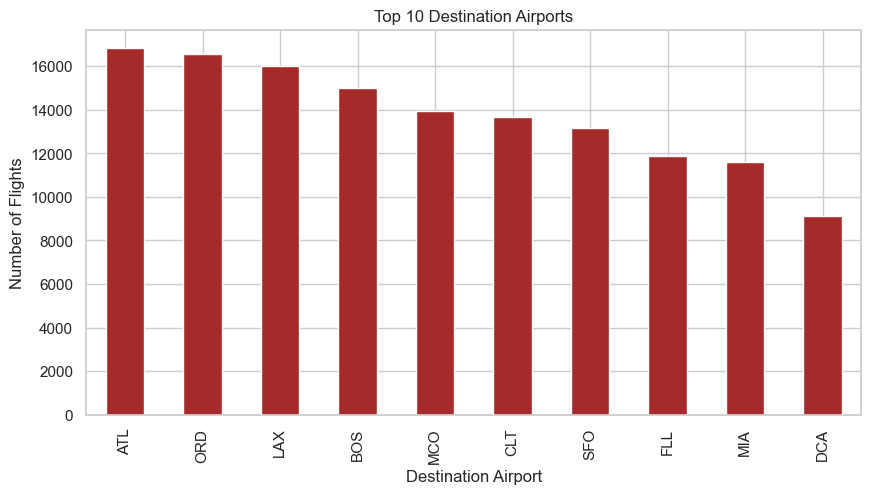

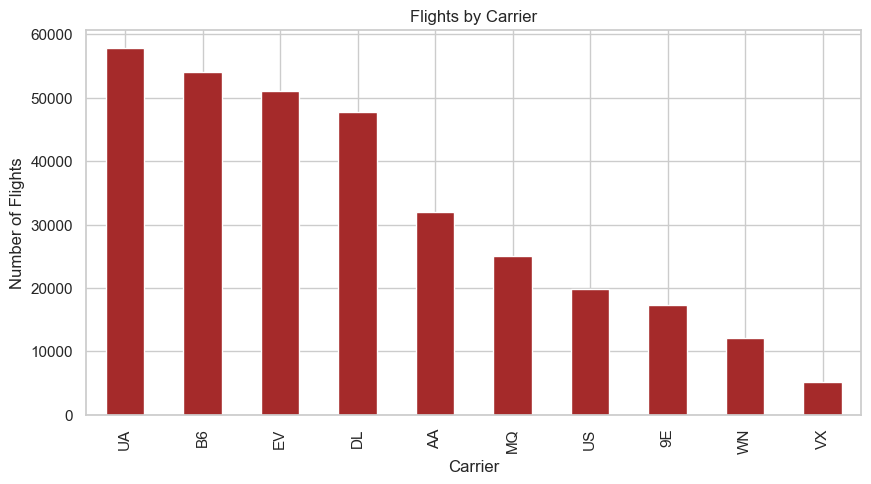

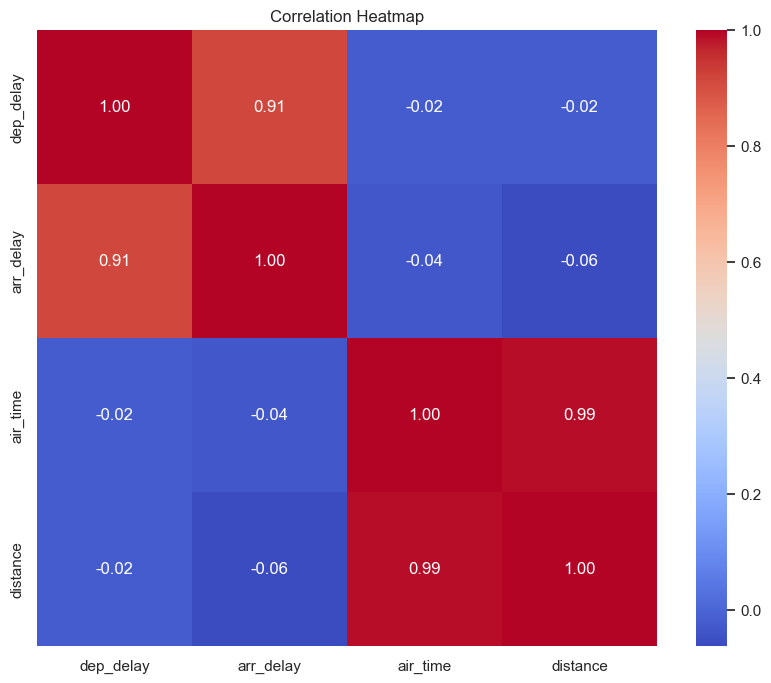

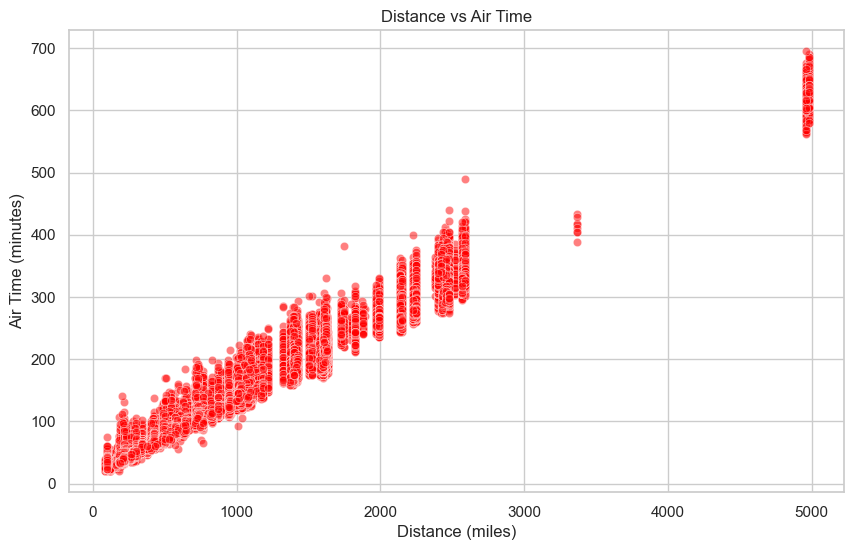

In [14]:
# function to plot count plots
def countPlot(df, fig_x, fig_y, x_plot, title, xlabel, ylabel):
  plt.figure(figsize=(fig_x, fig_y))
  sns.countplot(x=x_plot, data=df, palette='viridis')
  plt.title(title)
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  plt.show()

# function to create a histogram
def histogramPlot(df, num_bins, fig_x, fig_y, x_plot, title, xlabel, ylabel, plotcolor):
  plt.figure(figsize=(fig_x, fig_y))
  sns.histplot(df[x_plot], bins=num_bins, kde=True, color=plotcolor)
  plt.title(title)
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  plt.show()

# function to create a bargraph
def bargraphPlot(df, num_bars, fig_x, fig_y, x_plot, title, xlabel, ylabel, plotcolor):
  plt.figure(figsize=(fig_x, fig_y))
  df[x_plot].value_counts().head(num_bars).plot(kind='bar', color=plotcolor)
  plt.title(title)
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  plt.show()

def scatterPlot(df, fig_x, fig_y, x_plot, y_plot, title, xlabel, ylabel, plotcolor):
  plt.figure(figsize=(fig_x, fig_y))
  sns.scatterplot(x=x_plot, y=y_plot, data=df, alpha=0.5, color='red')
  plt.title(title)
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  plt.show()

histogramPlot(df, 50, 12, 6, 'dep_delay', 'Distribution of Departure Delays', 'Departure Delay (minutes)', 'Frequency', 'Blue') # the distribution of departure delayed flights on a histogram
histogramPlot(df, 50, 12, 6, 'arr_delay', 'Distribution of Arrival Delays', 'Arrival Delay (minutes)', 'Frequency', 'Green') # the distribution of arrival delay flights on a histogram
histogramPlot(df, 50, 12, 6, 'air_time', 'Distribution of Air Time', 'Air Time (minutes)', 'Frequency', 'Orange') # the distribution of air times on a histogram
histogramPlot(df, 24, 12, 6, 'dep_time', 'Distribution of Departure Times', 'Departure Time (24-hour format)', 'Frequency', 'Purple') # the distribution of departure times on a histogram
bargraphPlot(df, 10, 10, 7, 'origin', 'Origin', 'Origin Flights', 'Number of Flights', 'Teal') # the distribution of departure times on a histogram
bargraphPlot(df, 10, 10, 5, 'dest', 'Top 10 Destination Airports', 'Destination Airport', 'Number of Flights', 'Brown') # the distribution of departure times on a histogram
bargraphPlot(df, 10, 10, 5, 'carrier', 'Flights by Carrier', 'Carrier', 'Number of Flights', 'Brown') # carrier number of flights

# correlation heatmap
plt.figure(figsize=(10, 8))
corr = df[['dep_delay', 'arr_delay', 'air_time', 'distance']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

# scatter plot distance vs air time
scatterPlot(df, 10, 6, 'distance', 'air_time', 'Distance vs Air Time', 'Distance (miles)', 'Air Time (minutes)', 'Red')

# Findings:

Linear postive correlation between Air Time and Distance
Dataset imbalance between each flight and carrier


--------------------------------------------------------------------------------
# Month and Delays

The month might affect flight delays. To determine whether the month affects delays we can plot them using a bar graph and only include delayed flights.

C:\Users\Eric\AppData\Local\Temp\ipykernel_4736\726702339.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=x_plot, data=df, palette='viridis')


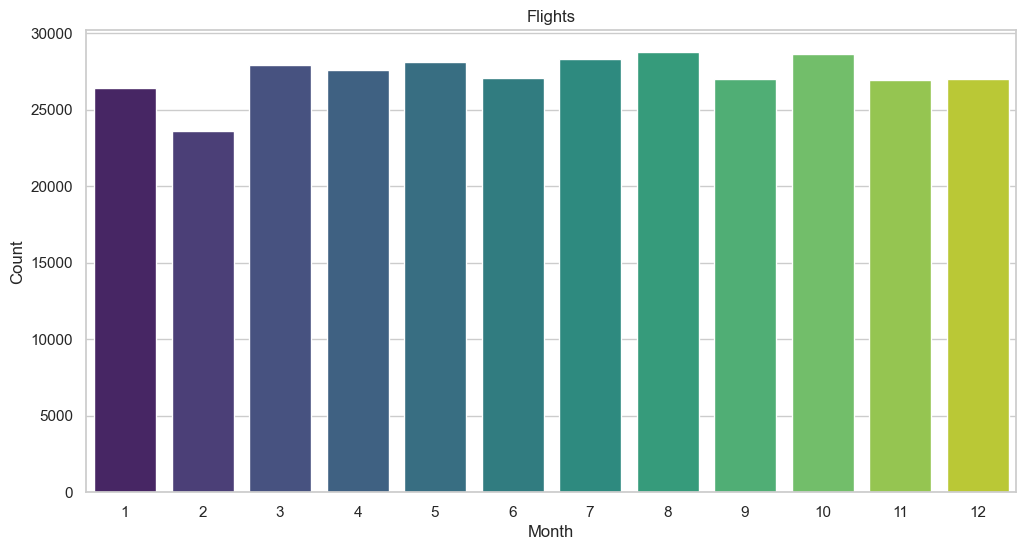

C:\Users\Eric\AppData\Local\Temp\ipykernel_4736\726702339.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=x_plot, data=df, palette='viridis')


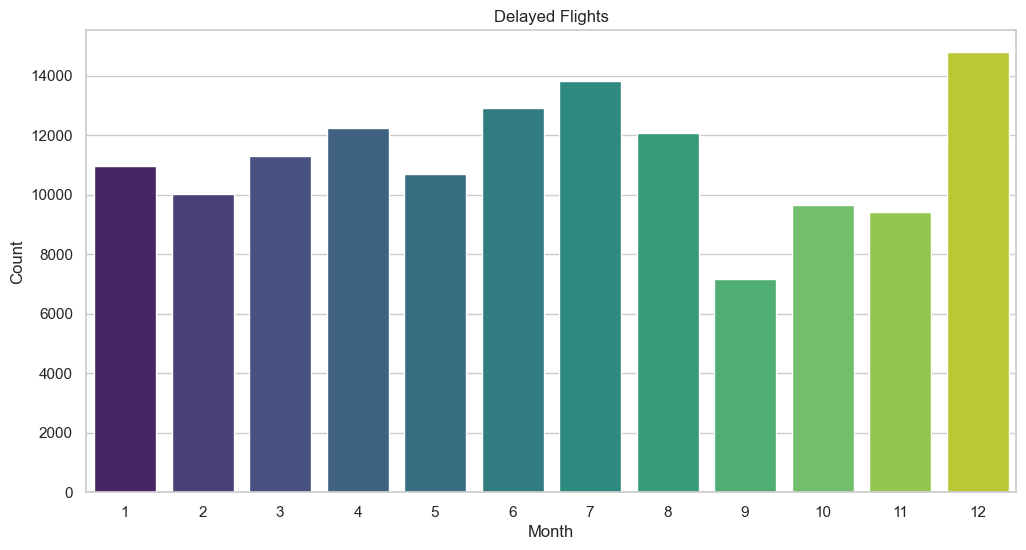

C:\Users\Eric\AppData\Local\Temp\ipykernel_4736\726702339.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=x_plot, data=df, palette='viridis')


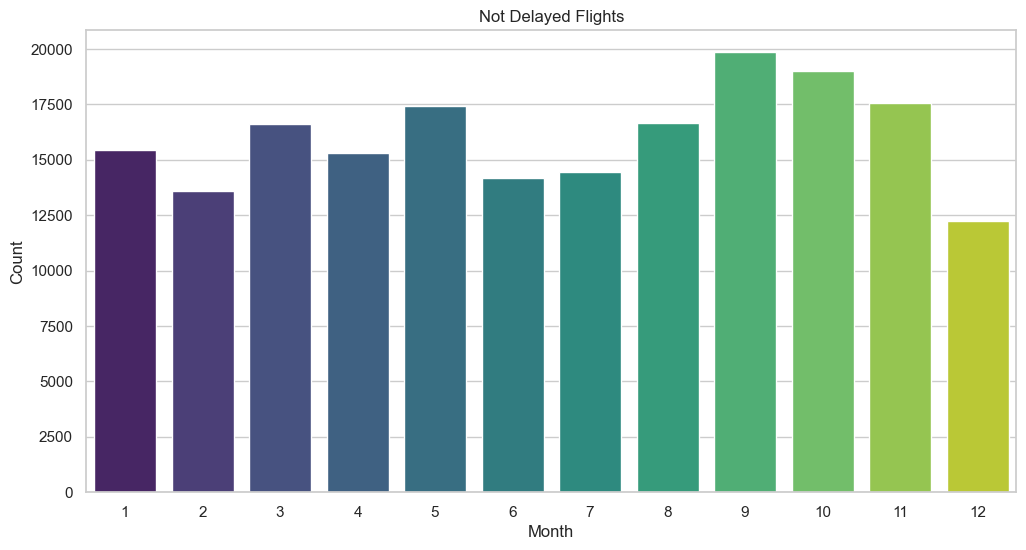

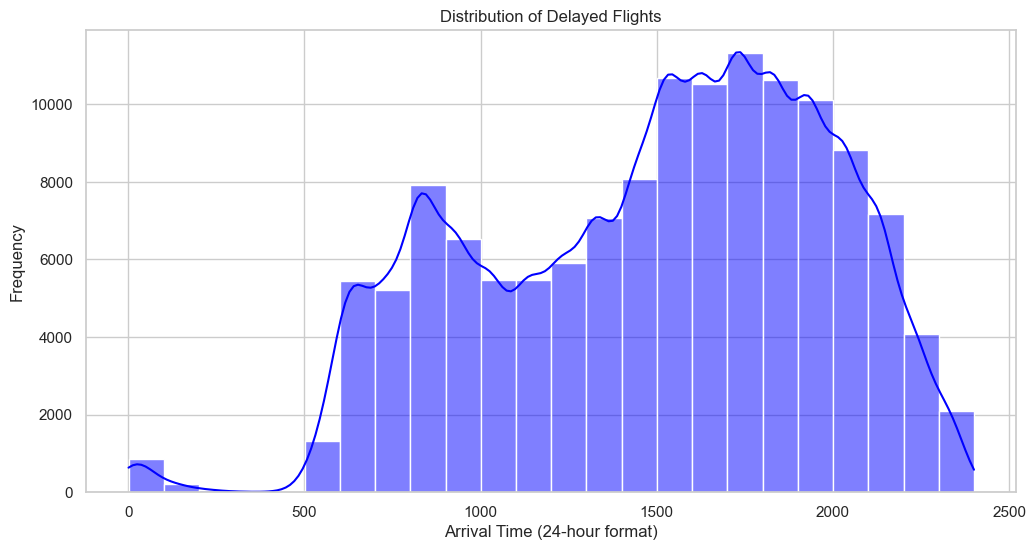

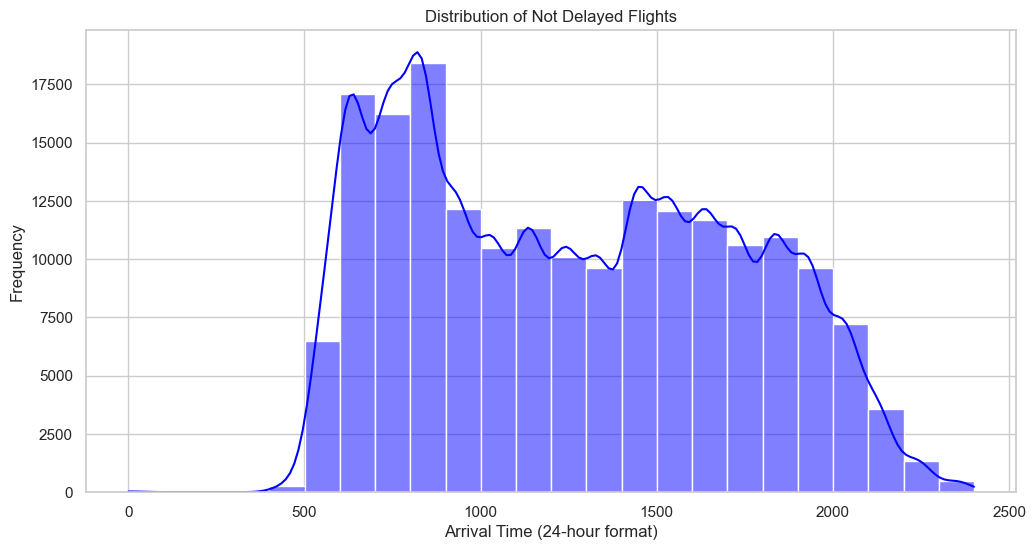

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df_delayed = df[df['total_delay'] > 0]
df_not_delayed = df[df['total_delay'] <= 0]

countPlot(df, 12, 6, 'month', 'Flights', 'Month', 'Count') # Number of all flights per month
countPlot(df_delayed, 12, 6, 'month', 'Delayed Flights', 'Month', 'Count') # Number of delayed flights per month
countPlot(df_not_delayed, 12, 6, 'month', 'Not Delayed Flights', 'Month', 'Count') # Number of not delayed flights per month

histogramPlot(df_delayed, 24, 12, 6, 'dep_time', 'Distribution of Delayed Flights', 'Arrival Time (24-hour format)', 'Frequency', 'Blue') # distribution of delayed flights
histogramPlot(df_not_delayed, 24, 12, 6, 'dep_time', 'Distribution of Not Delayed Flights', 'Arrival Time (24-hour format)', 'Frequency', 'Blue') # distrubiton of not delayed flights


# Findings

June, July, and August (Summer) have the most flight delays. We suspect it might be due to people being out on the holidays causing more travels, therefore more congestion. Also may be due to weather conditions since Summer is the prime time for thunderstorms.

November, December, and January (Winter) have the second most flight delays, but December has the most flight delays out of all months. We suspect it might be due to the holidays, and not weather related as January and November have lower delays than the months of summer.

In [16]:
df_all_month_flights = df.groupby('month')['total_delay'].count()
df_all_month_delayed_flights = df[df['total_delay'] > 0].groupby('month')['total_delay'].count()

month_percentage_delays = df_all_month_delayed_flights / df_all_month_flights
print(month_percentage_delays)

month
1     0.415827
2     0.423955
3     0.405383
4     0.444057
5     0.380333
6     0.476454
7     0.488884
8     0.420121
9     0.265198
10    0.336781
11    0.349486
12    0.547113
Name: total_delay, dtype: float64


# Carrier

We can also see if the Carrier affects the delays by calculating the mean for each of them. This can help determine which carrier is more likely to experience delays. The model might be able to find management issues between carriers, so we can make decisions internally.

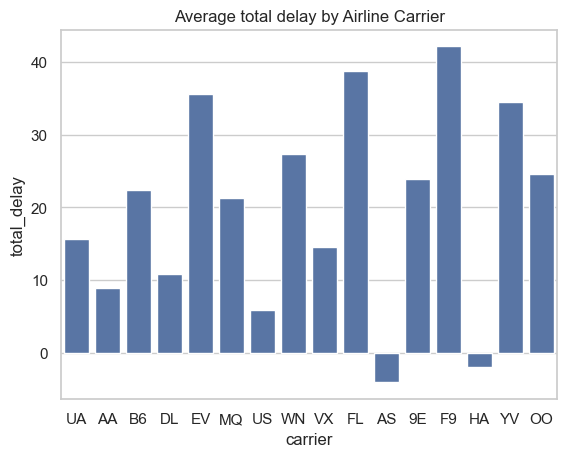

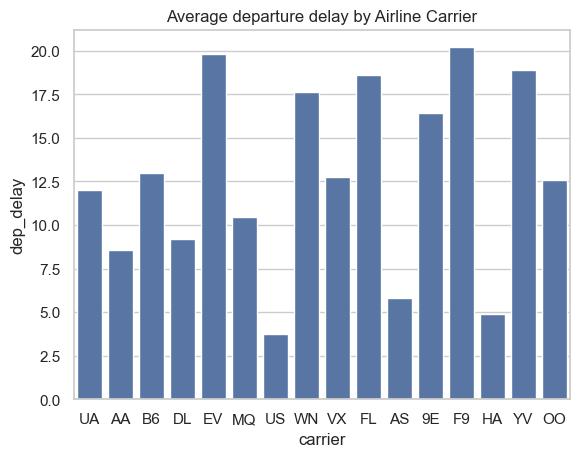

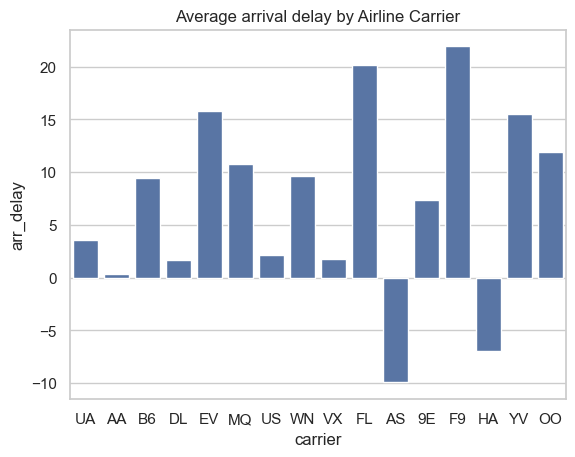

In [17]:

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv('flights_EDA.csv')

carrier_total_delay = df.groupby('carrier')['total_delay'].mean().reset_index()
carrier_dept_delay = df.groupby('carrier')['dep_delay'].mean().reset_index()
carrier_arr_delay = df.groupby('carrier')['arr_delay'].mean().reset_index()

def barPlot(x_label, y_label, title):
  sns.barplot(x=x_label, y=y_label, data=df, errorbar=None)
  plt.title(title)
  plt.show()

# print(carrier_total_delay)
# print(carrier_dept_delay)
# print(carrier_arr_delay)

barPlot('carrier', 'total_delay', 'Average total delay by Airline Carrier')
barPlot('carrier', 'dep_delay', 'Average departure delay by Airline Carrier')
barPlot('carrier', 'arr_delay', 'Average arrival delay by Airline Carrier')


# Findings

Interestingly, the arrival delay mean of AS and HA is below 0. This might be due to AS and HA rescheduling flights so they can minimize departure delays. We can also see that certain carriers have high delay means compared to others which could suggest managment issues.

--------------------------------------------------------------------------------
# Average Delay for Each hour

We can interpret the peak times for each hour by plotting each hour on a line graph along with its total delay

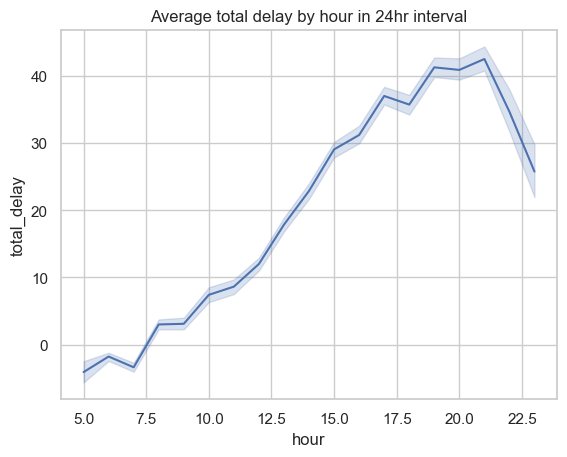

In [18]:

df['hour'] = pd.to_datetime(df['time_hour']).dt.hour
sns.lineplot(x='hour', y='total_delay', data= df)
plt.title('Average total delay by hour in 24hr interval')
plt.show()


# Peak Delay Hours

From examining this lineplot we can see that there is a peak from the hours of 10:00 to 19:00 in the 24-hour format
We can interpret from this that the peak period of delays is from 10:00am to 7:00pm, this indicates that
during these hours flights are inclined to face more departure delays

#Low Delay Hours
We can also interpret that the hours between 1:00am and 6:00am experience the lowest average dalays, which indicates that during
hours flights are inclined to face less delays

We can also see that As time increases (Hours throughout the day), flight delays tend to rise hitting a peak at around 19:00 to 20:00, but then
delays start decreasing after the peak hours, reducing the average departure delays

--------------------------------------------------------------------------------
# Numerical Features Analysis:

Before analyzing the numerical features, we aimed to understand the relationships between variables like departure delay, arrival delay, air time, distance, and the target variable, total delay. The scatter plots were used to visualize these relationships.

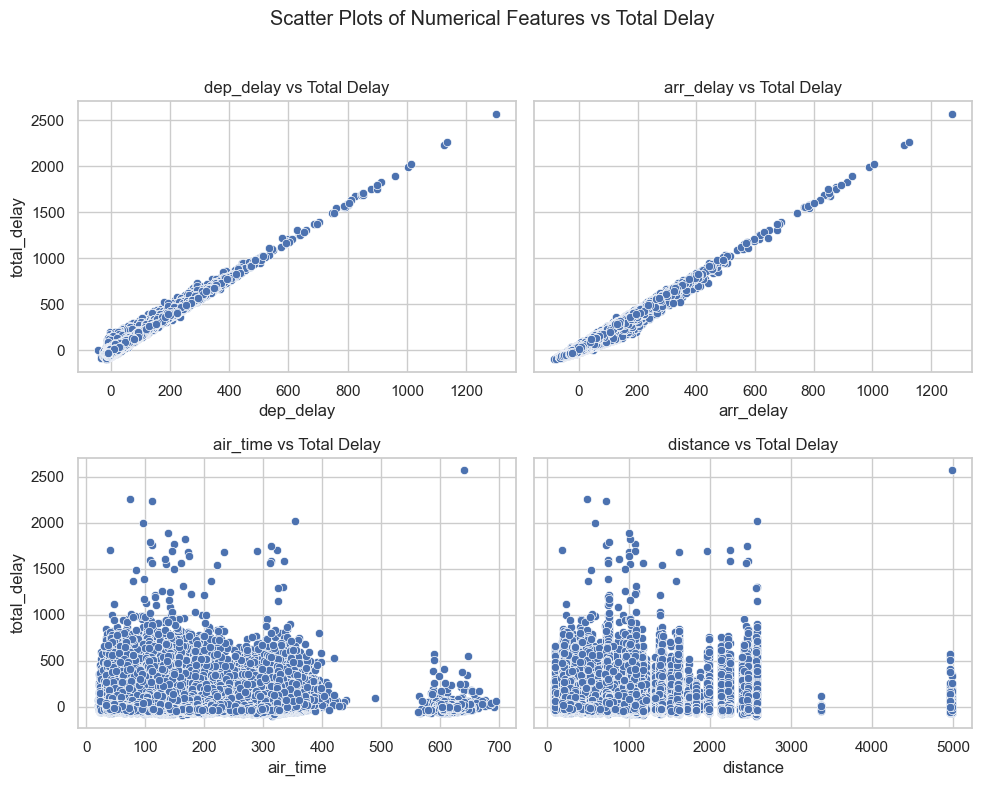

In [ ]:
import seaborn as sns

numerical_features = ['dep_delay', 'arr_delay', 'air_time', 'distance', 'total_delay']
import seaborn as sns
import matplotlib.pyplot as plt

numerical_features = ['dep_delay', 'arr_delay', 'air_time', 'distance', 'total_delay']

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8), sharey=True)
fig.suptitle('Scatter Plots of Numerical Features vs Total Delay')

def create_subplots(data, x_column, y_column, title, ax):
    sns.scatterplot(data=data, x=x_column, y=y_column, ax=ax)
    ax.set_title(title)
    ax.set_xlabel(x_column)
    ax.set_ylabel(y_column)

for i, col in enumerate(numerical_features[:-1]): 
    row = i // 2
    col_num = i % 2
    create_subplots(df, col, 'total_delay', f'{col} vs Total Delay', axes[row, col_num])

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# Findings

The correlation matrix obviously shows positive correlations between dep_delay, arr_delay, and total_delay, but since this data will not be known beforehand for future flights the model will not use them. The scatter plots confirmed these trends, showing clear linear relationships. In contrast, air_time and distance showed weak correlations with total_delay, suggesting they have minimal direct impact on delays.

--------------------------------------------------------------------------------
# Categorical Features Analysis:

For the categorical features (carrier, origin, and destination), we one-hot encoded the variables and created scatter plots to explore their relationship with total_delay.

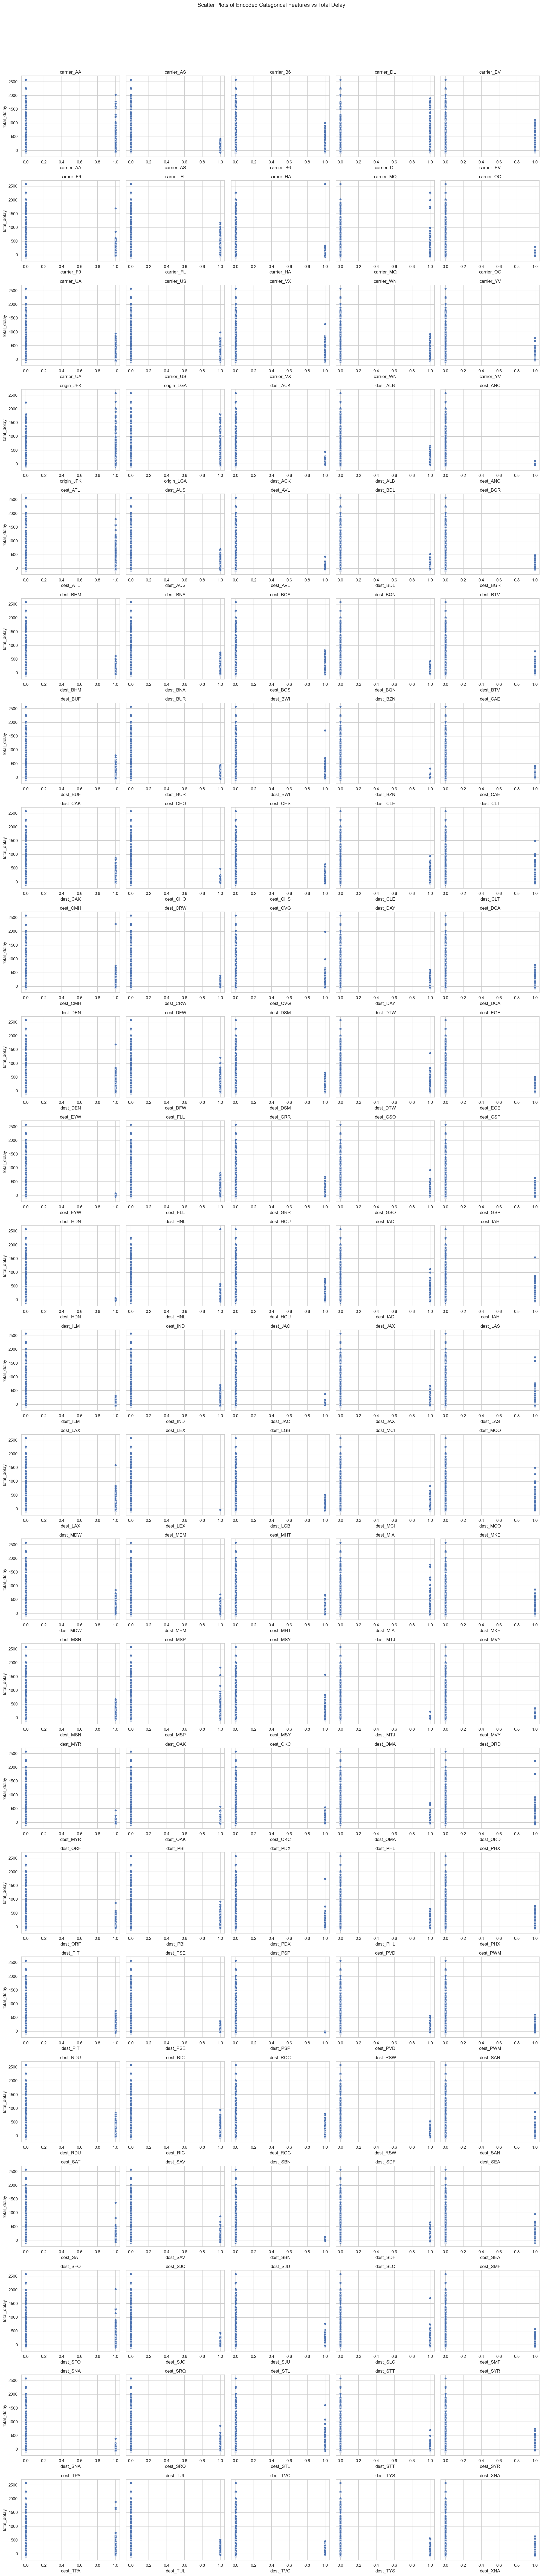

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

categorical_features = ['carrier', 'origin', 'dest']
df_encoded = pd.get_dummies(df, columns=categorical_features, drop_first=True)
target_column = 'total_delay'

df_encoded.head()

encoded_categorical_columns = [col for col in df_encoded.columns if col.startswith(tuple(categorical_features))]

num_features = len(encoded_categorical_columns)
num_cols = 5 
num_rows = (num_features // num_cols) + (1 if num_features % num_cols != 0 else 0)

fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(20, 4 * num_rows), sharey=True)
fig.suptitle('Scatter Plots of Encoded Categorical Features vs Total Delay')

def create_subplots(data, x_column, y_column, title, ax):
    sns.scatterplot(data=data, x=x_column, y=y_column, ax=ax)
    ax.set_title(title)
    ax.set_xlabel(x_column)
    ax.set_ylabel(y_column)

for i, col in enumerate(encoded_categorical_columns):
    row = i // num_cols
    col_num = i % num_cols
    create_subplots(df_encoded, col, target_column, col, axes[row, col_num])

for i in range(num_features, num_rows * num_cols):
    fig.delaxes(axes.flatten()[i])

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# Findings

The scatter plots for the encoded categorical features did not reveal strong visual trends, as the binary nature of one-hot encoded variables makes it challenging to discern clear patterns. However, this analysis helps identify which specific carriers, origins, or destinations might have higher or lower delays, which can be further investigated using statistical tests or located in the classification modelling phase. The lack of clear trends suggests that categorical features may have a more nuanced or indirect impact on delays, requiring deeper analysis.

--------------------------------------------------------------------------------
# Outlier Detection

We use the Interquartile Range (IQR) method to identify outliers. The IQR is the range between the first quartile (25th percentile, Q1) and the third quartile (75th percentile, Q3). Any data point that falls below Q1 - 1.5 * IQR or above Q3 + 1.5 * IQR is considered an outlier.

This information helps us understand which features are most affected by extreme values and guides further analysis.

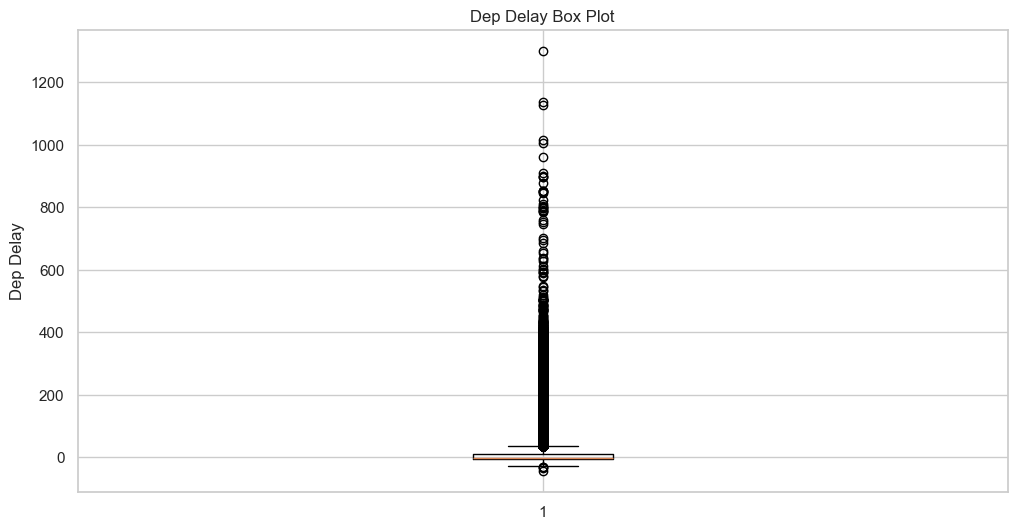

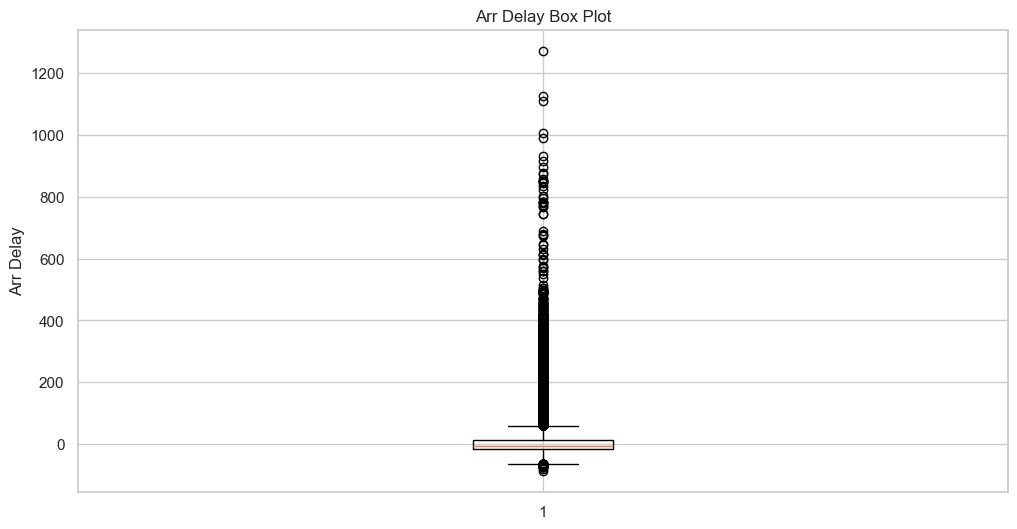

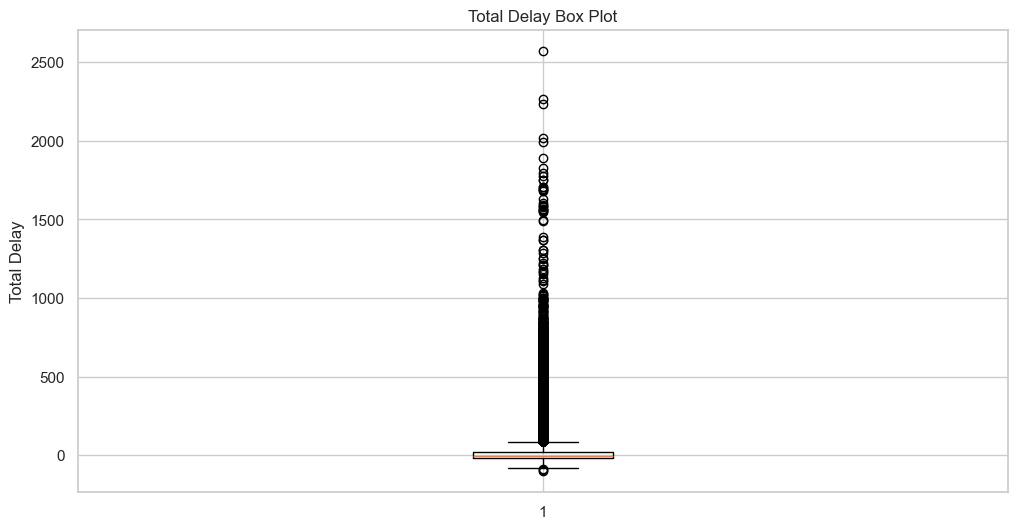

In [21]:
plt.figure(figsize=(12, 6))
plt.boxplot(df['dep_delay'])
plt.title('Dep Delay Box Plot')
plt.ylabel('Dep Delay')
plt.show()

plt.figure(figsize=(12, 6))
plt.boxplot(df['arr_delay'])
plt.title('Arr Delay Box Plot')
plt.ylabel('Arr Delay')
plt.show()

plt.figure(figsize=(12, 6))
plt.boxplot(df['total_delay'])
plt.title('Total Delay Box Plot')
plt.ylabel('Total Delay')
plt.show()

In [22]:
# Detect outliers using IQR
for feature in numerical_features:
    Q1 = df[feature].quantile(0.25)
    Q3 = df[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[feature] < lower_bound) | (df[feature] > upper_bound)]
    print(f"Outliers in {feature}: {len(outliers)}")

Outliers in dep_delay: 42857
Outliers in arr_delay: 27880
Outliers in air_time: 5448
Outliers in distance: 709
Outliers in total_delay: 36433


# Findings

There are a few outlier delays but there is there might be a reason for them. Extreme weather could be the cause, or other factors. Therefore we did not remove them

# Date and Holidays

Since we suspected Holidays and the month, and its day might contribute to delays earlier, we need to plot each date on a line graph along with its mean delay time.

In [23]:
import pandas as pd
import datetime
import holidays

df = pd.read_csv('flights_EDA.csv')

us_holidays = holidays.US(years=[2013])


df['time_hour'] = pd.to_datetime(df['time_hour'])

df['date'] = df['time_hour'].dt.normalize()


df['is_holiday'] = df['date'].isin(us_holidays)

C:\Users\Eric\AppData\Local\Temp\ipykernel_4736\1628942851.py:15: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  df['is_holiday'] = df['date'].isin(us_holidays)


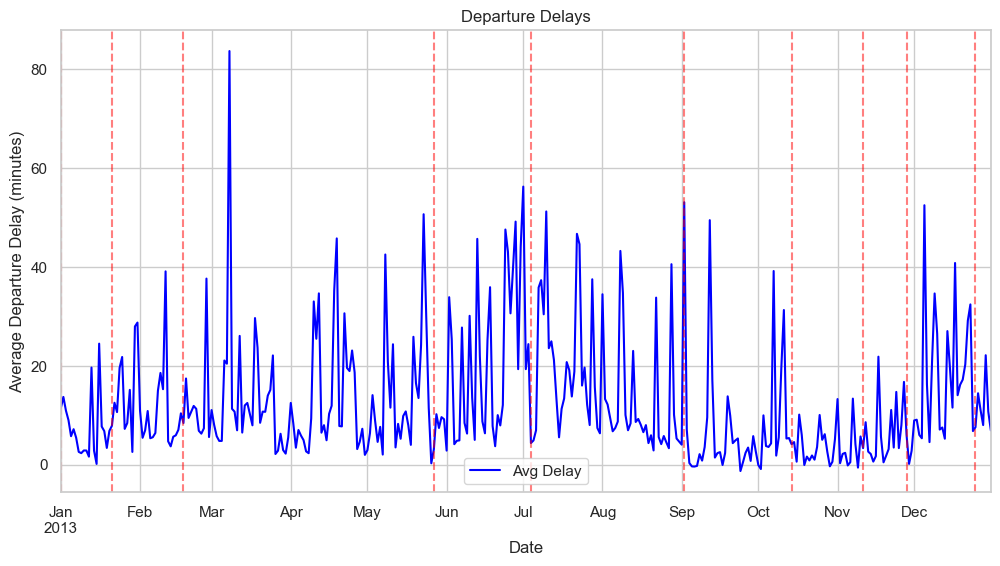

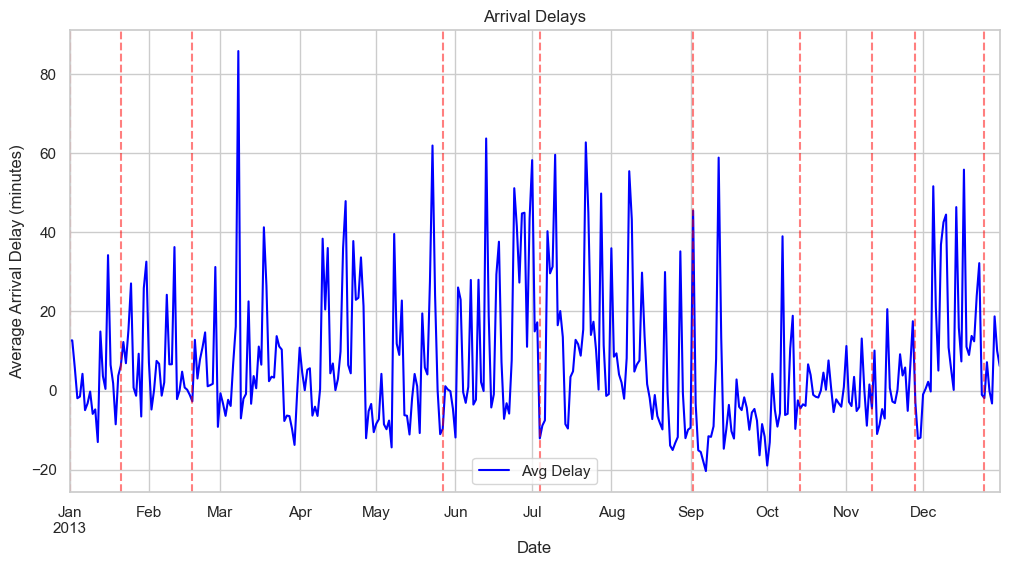

In [24]:
import pandas as pd
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

df.groupby('date')['dep_delay'].mean().plot(label="Avg Delay", color='blue')

holiday_dates = df[df['is_holiday']]['date'].unique()
for h_date in holiday_dates:
    plt.axvline(h_date, color='red', linestyle='--', alpha=0.5)

plt.xlabel("Date")
plt.ylabel("Average Departure Delay (minutes)")
plt.title("Departure Delays")
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))

df.groupby('date')['arr_delay'].mean().plot(label="Avg Delay", color='blue')

holiday_dates = df[df['is_holiday']]['date'].unique()
for h_date in holiday_dates:
    plt.axvline(h_date, color='red', linestyle='--', alpha=0.5)

plt.xlabel("Date")
plt.ylabel("Average Arrival Delay (minutes)")
plt.title("Arrival Delays")
plt.legend()
plt.show()

# Findings

Delay times seem to spike on Certain Holidays. Also, there are a few dates where there is a large spike when they arent a holiday. This is could be weather related.

-----------------
# Feature Engineering

Since the season matters in flight delays we can categorize each month to their respective season

In [ ]:
def categorize_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    elif month in [9, 10, 11]:
        return 'Fall'

df['season'] = df['month'].apply(categorize_season)


# Peak Times

We can use a histogram and see the peak times for Departure Delays and Arrival Delays. We can use the distribution to indicate which hours suggest peak times.

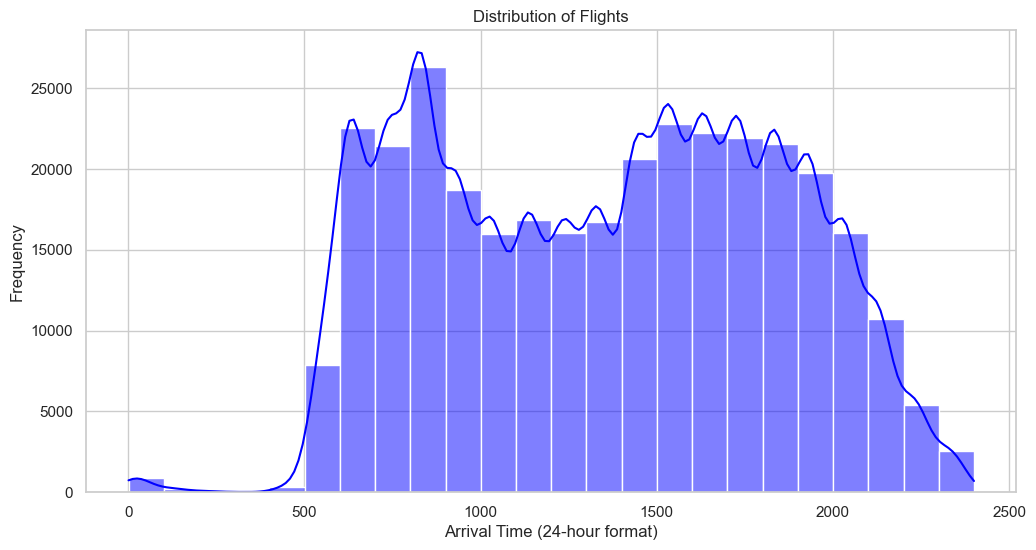

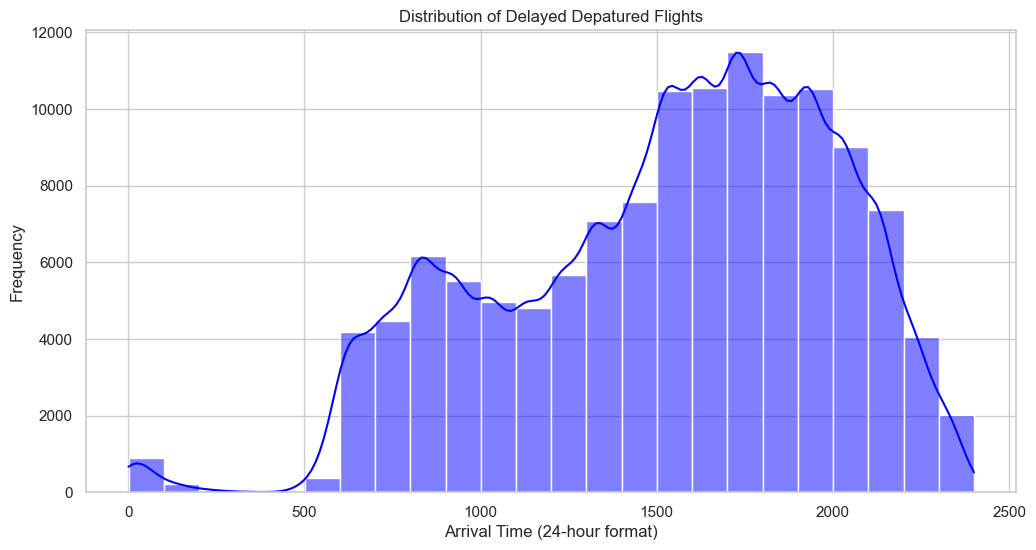

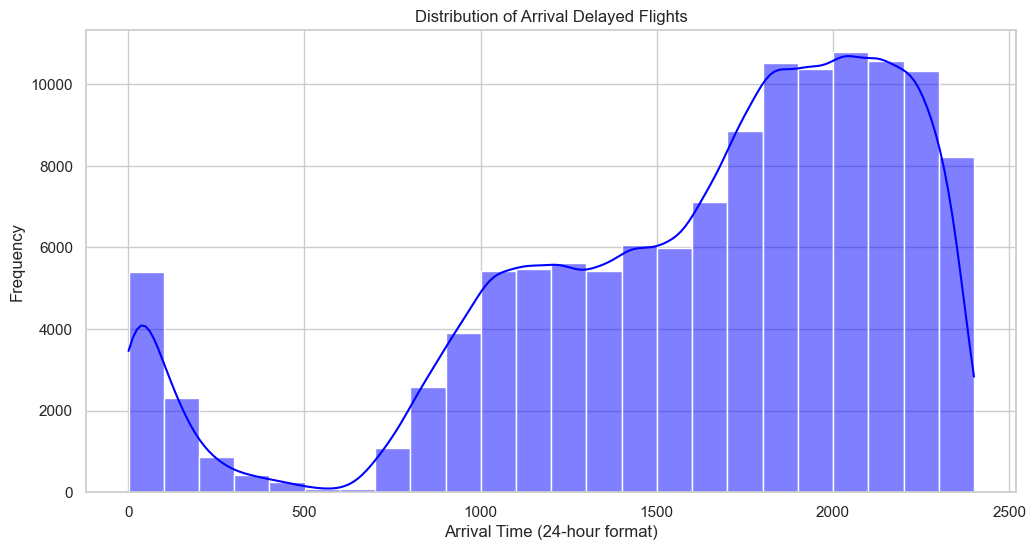

In [26]:
df_dep_delay = df[df['dep_delay'] > 0]
df_arr_delay = df[df['arr_delay'] > 0]

plt.figure(figsize=(12, 6))
sns.histplot(df['dep_time'], bins=24, kde=True, color='Blue')
plt.title('Distribution of Flights')
plt.xlabel('Arrival Time (24-hour format)')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(12, 6))
sns.histplot(df_dep_delay['dep_time'], bins=24, kde=True, color='Blue')
plt.title('Distribution of Delayed Depatured Flights')
plt.xlabel('Arrival Time (24-hour format)')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(12, 6))
sns.histplot(df_dep_delay['arr_time'], bins=24, kde=True, color='Blue')
plt.title('Distribution of Arrival Delayed Flights')
plt.xlabel('Arrival Time (24-hour format)')
plt.ylabel('Frequency')
plt.show()

# Findings:

Departure Delays tend to peak at 15:00-20:00, while Arrival times tend to peak at 16:00-23:59.

-----------
# Feature Engineering

We can categorize these peak times to improve our model. Depending on performance this feature be included or not.

In [27]:
# feature engineering for dep peak times
def dep_time_category(hour):
    if 0 <= hour < 600:
        return "early_morning"
    elif 600 <= hour < 1200:
        return "morning"
    elif 1200 <= hour < 1500:
        return "afternoon"
    elif 1500 <= hour < 2000:
        return "afternoon/evening_dep_rush"
    else:
        return 'evening'

# feature engineering for arr peak times
def arr_time_category(hour):
    if 0 <= hour < 100:
        return "early_morning_rush"
    elif 100 <= hour < 700:
        return "early_morning_slowdown"
    elif 700 <= hour < 1200:
        return "morning"
    elif 1200 <= hour < 1600:
        return "afternoon"
    elif 1600 <= hour < 2400:
        return "evening_rush"

# add the new column
df["dep_time_category"] = df["dep_time"].apply(dep_time_category)
df["arr_time_category"] = df["arr_time"].apply(dep_time_category)

In [28]:
# remove noise
df = df[df['air_time'] > 0]

df.to_csv('flights_EDA.csv', index=False)

# Airport Flight Weather Dataset Merge

Since we suspected delays might be caused by weather, we need the weather data for the airports for each date and time. We managed to find a weather dataset with the airports weather for all dates and times.

In [29]:
# weather airport dataset merge to main flights
df = pd.read_csv('flights_EDA.csv')
wdf = pd.read_csv('weather.csv')

df_weather_merge = pd.merge(df, wdf, on=['origin', 'month', 'day', 'hour', 'year'])

df_weather_merge.to_csv('merged_flight_weather_data.csv', index=False)




# KNN

After merging we use KNN to fill the missing weather values caused by the merge.

In [ ]:
import pandas as pd
from sklearn.impute import KNNImputer
import os

output_file = 'merged_flight_weather_data_knn.csv'

if not os.path.exists(output_file):
    print("Processing file... (This may take ~30 minutes)")
    
    # Load
    df_flights_weather = pd.read_csv('merged_flight_weather_data.csv')

    # Check missing values
    missing_values = df_flights_weather.isnull().sum()
    missing_values = missing_values[missing_values > 0]
    print("Missing values found:")
    print(missing_values)

    missing_columns = ['temp', 'dewp', 'humid', 'wind_dir', 'wind_speed', 'wind_gust', 'pressure']

    imputer = KNNImputer(n_neighbors=5)
    df_flights_weather[missing_columns] = imputer.fit_transform(df_flights_weather[missing_columns])

    df_flights_weather.to_csv(output_file, index=False)
    print(f"File saved as {output_file}")
else:
    print(f"File {output_file} already exists - skipping imputation")

File merged_flight_weather_data_knn.csv already exists - skipping imputation


In [31]:
df_flights_weather = pd.read_csv('merged_flight_weather_data_knn.csv')
missing_values = df_flights_weather.isnull().sum()
print(missing_values)

id                   0
year                 0
month                0
day                  0
dep_time             0
sched_dep_time       0
dep_delay            0
arr_time             0
sched_arr_time       0
arr_delay            0
carrier              0
flight               0
tailnum              0
origin               0
dest                 0
air_time             0
distance             0
hour                 0
minute               0
time_hour_x          0
name                 0
missing_count        0
flight_status        0
total_delay          0
date                 0
is_holiday           0
season               0
dep_time_category    0
arr_time_category    0
temp                 0
dewp                 0
humid                0
wind_dir             0
wind_speed           0
wind_gust            0
precip               0
pressure             0
visib                0
time_hour_y          0
dtype: int64


# Precipitation

Our goal is to see whether Precipitation effects flight delays. Therefore we can plot the precipitation values and its mean delay times to see if there are any patterns.

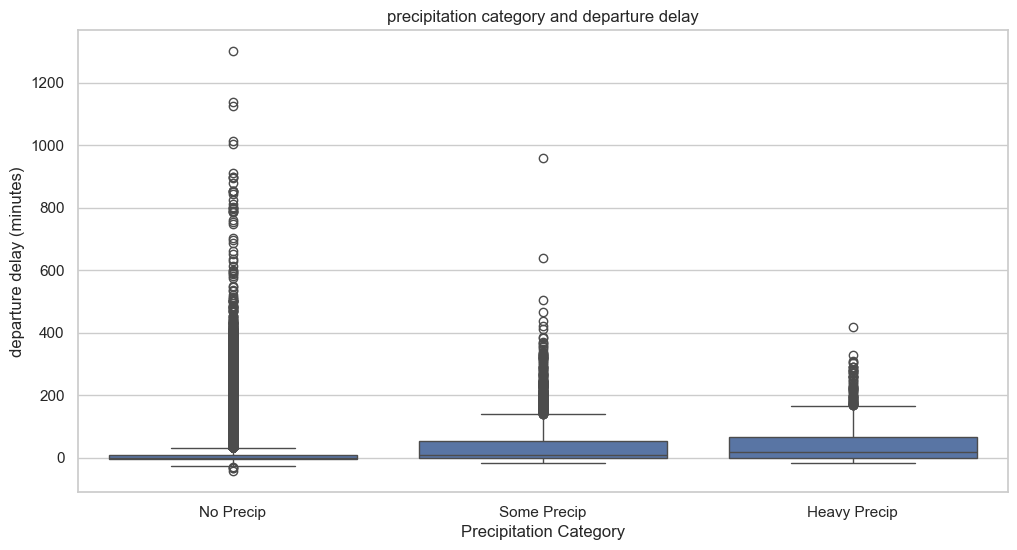

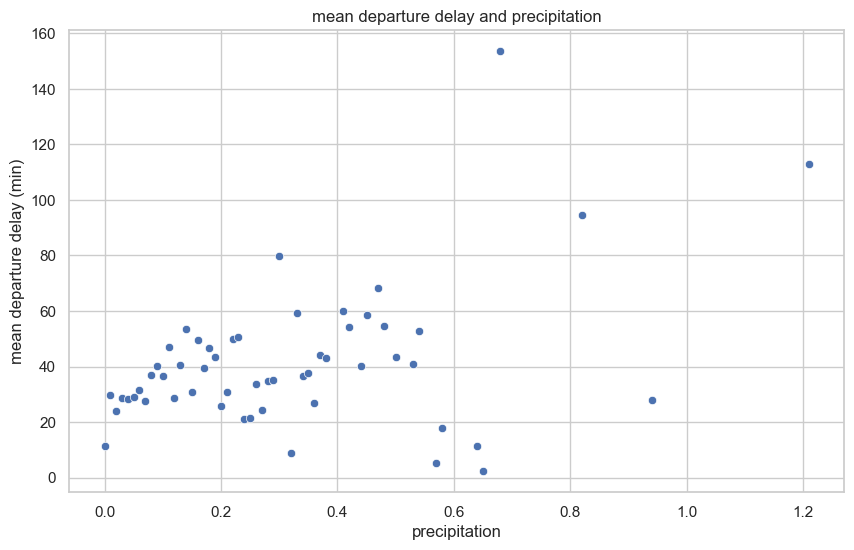

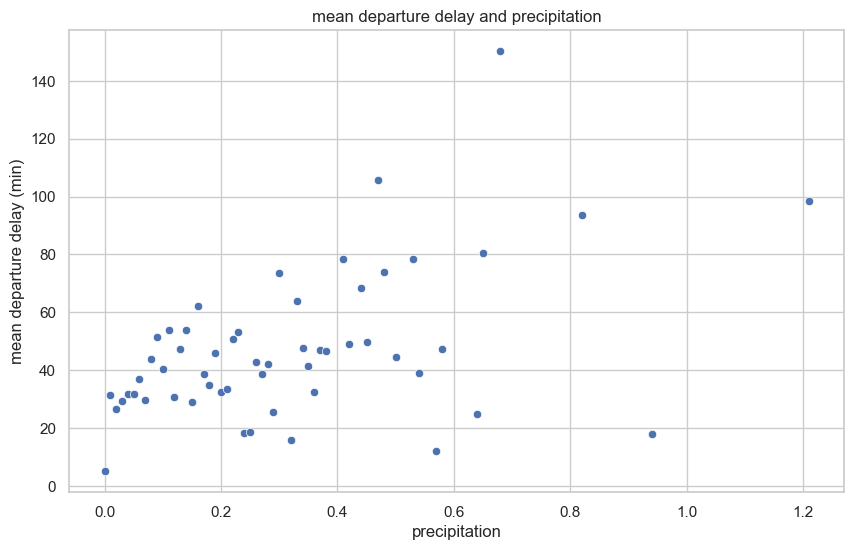

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df_flights_weather = pd.read_csv('merged_flight_weather_data_knn.csv')

# bin the precipitation values into categories
df_flights_weather['precip_category'] = pd.cut(df_flights_weather['precip'], bins=[0, 0.1, 0.3, float('inf')], labels=['No Precip', 'Some Precip', 'Heavy Precip'], right=False)

#boxplot them
plt.figure(figsize=(12, 6))
sns.boxplot(x='precip_category', y='dep_delay', data=df_flights_weather)
plt.title('precipitation category and departure delay')
plt.xlabel('Precipitation Category')
plt.ylabel('departure delay (minutes)')
plt.show()

#get the depature delay mean for precip values
mean_dep_delay_percip = df_flights_weather.groupby('precip')['dep_delay'].mean().reset_index()

# plot them against dep delay
plt.figure(figsize=(10, 6))
sns.scatterplot(x='precip', y='dep_delay', data=mean_dep_delay_percip)
plt.title('mean departure delay and precipitation')
plt.xlabel('precipitation')
plt.ylabel('mean departure delay (min)')
plt.show()

#get the depature delay mean for precip values
mean_arr_delay_percip = df_flights_weather.groupby('precip')['arr_delay'].mean().reset_index()
# plot them against arr delay
plt.figure(figsize=(10, 6))
sns.scatterplot(x='precip', y='arr_delay', data=mean_arr_delay_percip)
plt.title('mean departure delay and precipitation')
plt.xlabel('precipitation')
plt.ylabel('mean departure delay (min)')
plt.show()

df_flights_weather['precip_category'] = pd.cut(df_flights_weather['precip'], bins=[0, 0.1, 0.3, float('inf')], labels=['No Precip', 'Some Precip', 'Heavy Precip'], right=False)

# Findings

There seems to be a positive correlation between preciipitation and its mean delay times. The higher the precipitation value the higher the delay time is indicating precipitation is a factor in delays.

# Dew point

We can find if other weather variables effect delays such as dew point. We can use the same method previously to see if dew point effects delays.

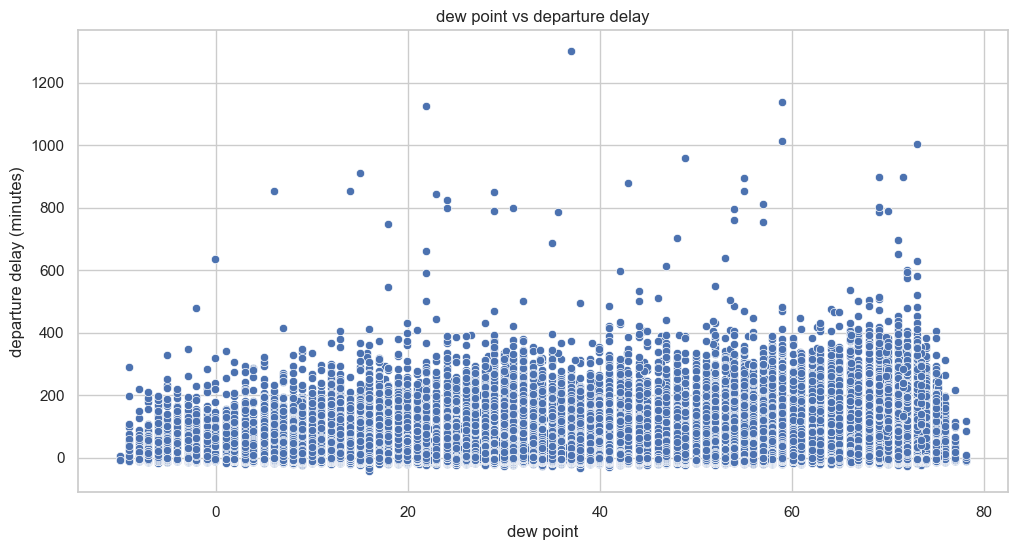

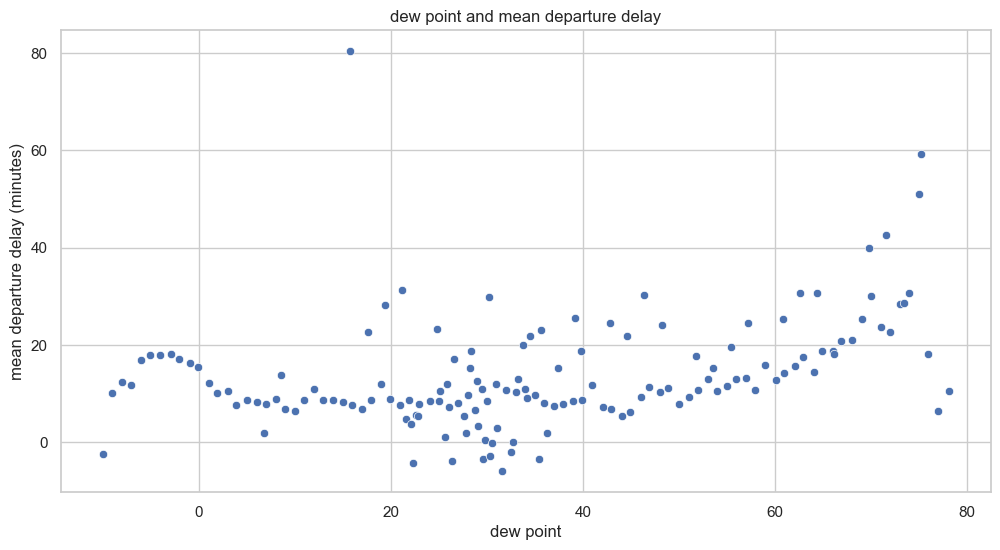

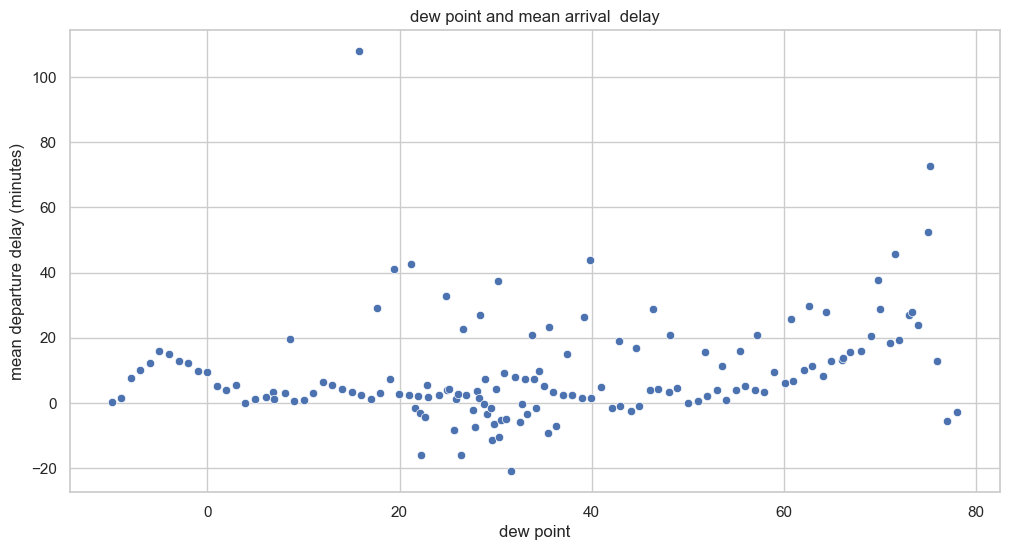

In [33]:
# plot dewpoint and departure delays
plt.figure(figsize=(12, 6))
sns.scatterplot(x='dewp', y='dep_delay', data=df_flights_weather)
plt.title('dew point vs departure delay')
plt.xlabel('dew point')
plt.ylabel('departure delay (minutes)')
plt.show()

# mean dep delay for dewpoint values
mean_dep_delay_dewp = df_flights_weather.groupby("dewp")["dep_delay"].mean().reset_index()

# plot dew point and mean dep delay
plt.figure(figsize=(12, 6))
sns.scatterplot(x='dewp', y='dep_delay', data=mean_dep_delay_dewp)
plt.title('dew point and mean departure delay')
plt.xlabel('dew point')
plt.ylabel('mean departure delay (minutes)')
plt.show()

mean_arr_delay_dewp = df_flights_weather.groupby('dewp')['arr_delay'].mean().reset_index()

# plot dew point and mean arrival delay
plt.figure(figsize=(12, 6))
sns.scatterplot(x='dewp', y='arr_delay', data=mean_arr_delay_dewp)
plt.title('dew point and mean arrival  delay')
plt.xlabel('dew point')
plt.ylabel('mean departure delay (minutes)')
plt.show()

# Findings

There seems to be no meaningful pattern between dew point and delays. There is no linear correlation or anything interesting in the graph.

--------------
# Humidity

We can use the same method to find the patterns between humidity and the delays

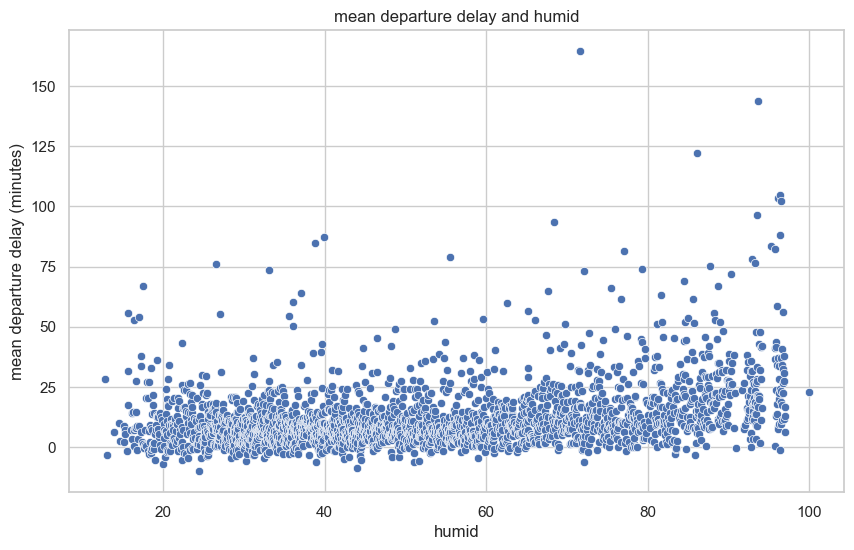

In [34]:
mean_dep_delay_visib = df_flights_weather.groupby('humid')['dep_delay'].mean().reset_index()

# plot of visibility and dep delay
plt.figure(figsize=(10, 6))
sns.scatterplot(x='humid', y='dep_delay', data=mean_dep_delay_visib)
plt.title('mean departure delay and humid')
plt.xlabel('humid')
plt.ylabel('mean departure delay (minutes)')
plt.show()

# Findings

There doesnt seem to be anything meaningful between humidity and delay time shown in the graph. Therefore humidity does not effect flight delays.

# Visibility

We can use the same method to find if visibility effects delays.

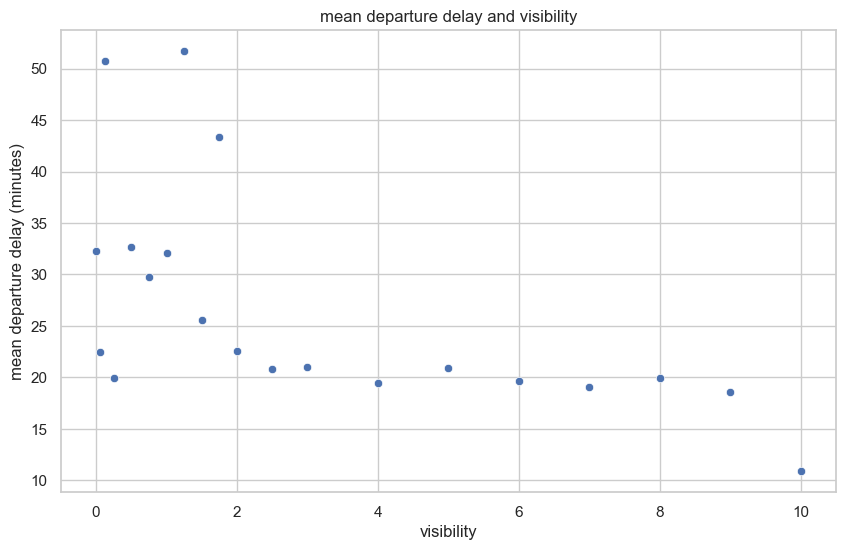

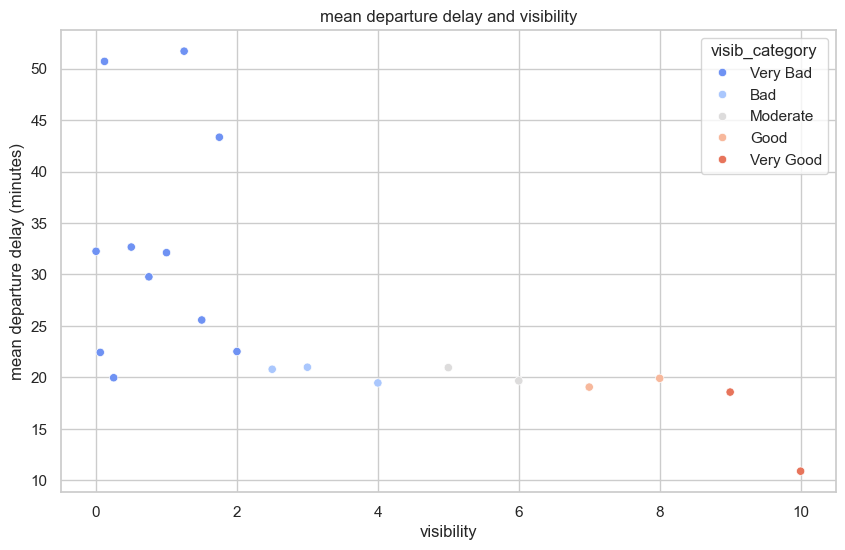

In [35]:
# dep delay mean for visibility values
mean_dep_delay_visib = df_flights_weather.groupby('visib')['dep_delay'].mean().reset_index()

# plot of visibility and dep delay
plt.figure(figsize=(10, 6))
sns.scatterplot(x='visib', y='dep_delay', data=mean_dep_delay_visib)
plt.title('mean departure delay and visibility')
plt.xlabel('visibility')
plt.ylabel('mean departure delay (minutes)')
plt.show()

# bin the visibility values into categorical attributes for feature engieering
wind_visb_bin = [-float('inf'), 2, 4, 6, 8, float('inf')]
wind_visb_label = ['Very Bad', 'Bad', 'Moderate', 'Good', 'Very Good']

mean_dep_delay_visib['visib_category'] = pd.cut(mean_dep_delay_visib['visib'], bins=wind_visb_bin, labels=wind_visb_label)

# show the bins
plt.figure(figsize=(10, 6))
sns.scatterplot(x='visib', y='dep_delay', data=mean_dep_delay_visib, hue="visib_category", palette="coolwarm")
plt.title('mean departure delay and visibility')
plt.xlabel('visibility')
plt.ylabel('mean departure delay (minutes)')
plt.legend(title='visib_category')
plt.show()

# add new category
df_flights_weather['visib_category'] = pd.cut(df_flights_weather['visib'], bins=wind_visb_bin, labels=wind_visb_label)


# Findings

Low Visibility values between 0-2 is a major cause in delays. Low Visibility indicates pilots have a hard time seeing therefore causing higher delays.

-----------------
# Wind Speed

We can use the same method to find if wind speed effects delays

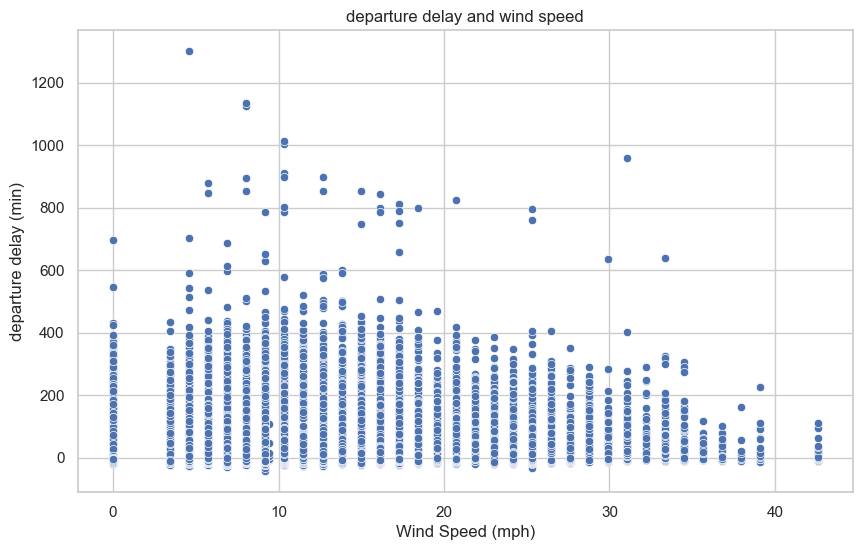

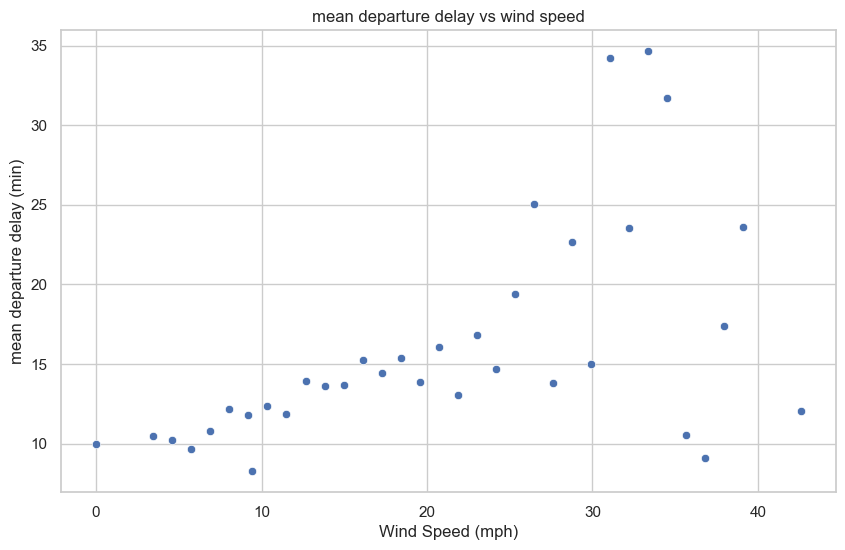

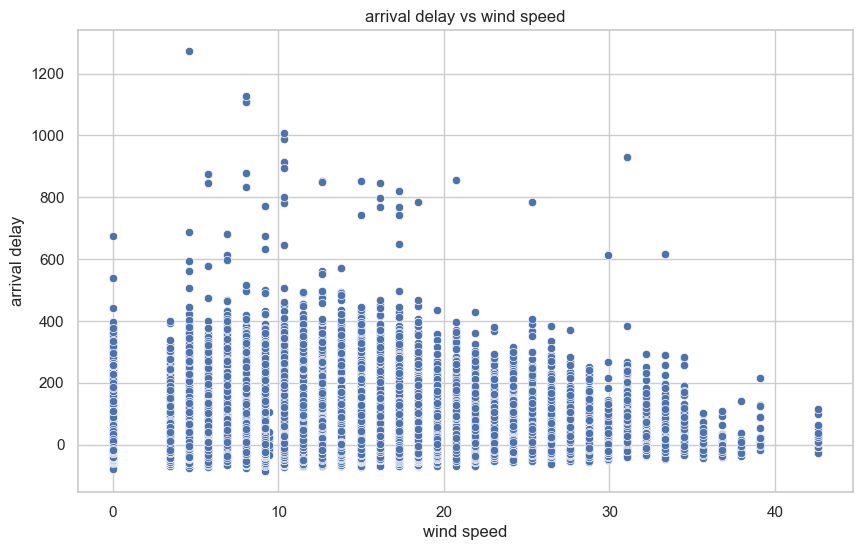

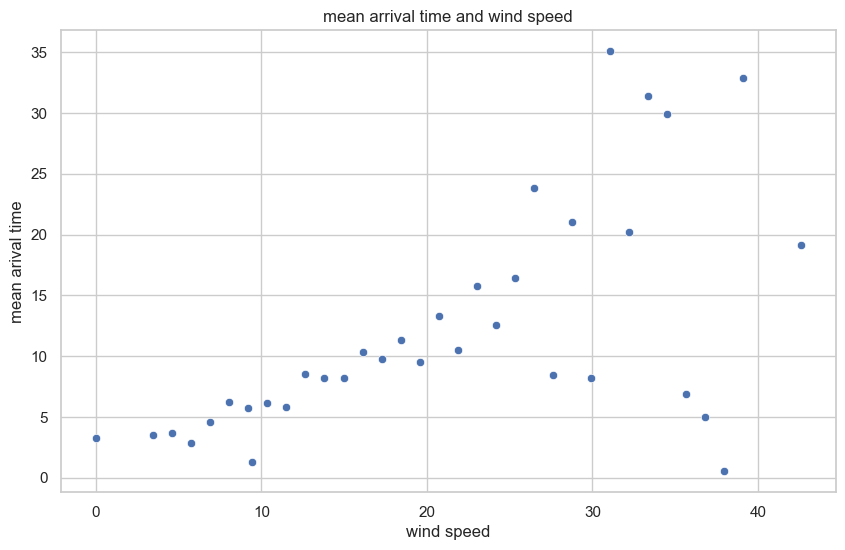

In [36]:
# plot the wind speed and dep delay
plt.figure(figsize=(10, 6))
sns.scatterplot(x='wind_speed', y='dep_delay', data=df_flights_weather)
plt.title('departure delay and wind speed')
plt.xlabel('Wind Speed (mph)')
plt.ylabel('departure delay (min)')
plt.show()

mean_dep_delay_wind_speed = df_flights_weather.groupby('wind_speed')['dep_delay'].mean().reset_index()

# plot the mean dep_delay and wind_speed
plt.figure(figsize=(10, 6))
sns.scatterplot(x='wind_speed', y='dep_delay', data=mean_dep_delay_wind_speed)
plt.title('mean departure delay vs wind speed')
plt.xlabel('Wind Speed (mph)')
plt.ylabel('mean departure delay (min)')
plt.show()

# plot the arr_delay and wind_speed
plt.figure(figsize=(10, 6))
sns.scatterplot(x='wind_speed', y='arr_delay', data=df_flights_weather)
plt.title('arrival delay vs wind speed')
plt.xlabel('wind speed')
plt.ylabel('arrival delay')
plt.show()

mean_arr_delay_wind_speed = df_flights_weather.groupby('wind_speed')['arr_delay'].mean().reset_index()

# plot mean arr_delay and wind_speed
plt.figure(figsize=(10, 6))
sns.scatterplot(x='wind_speed', y='arr_delay', data=mean_arr_delay_wind_speed)
plt.title('mean arrival time and wind speed')
plt.xlabel('wind speed')
plt.ylabel('mean arival time')
plt.show()


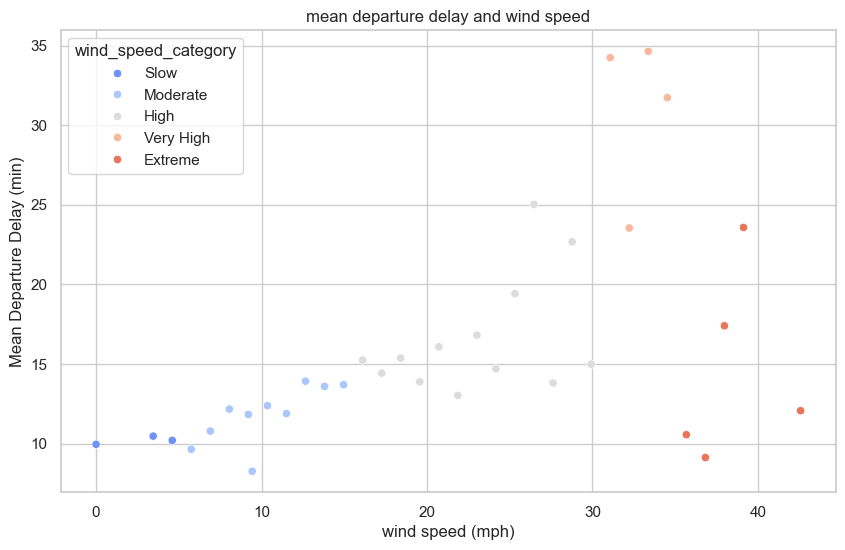

In [37]:
# create the bin for the wind gust value
wind_speed_bin = [-float('inf'), 5, 15, 30, 35, float('inf')]
wind_speed_label = ['Slow', 'Moderate', 'High', 'Very High', 'Extreme']


mean_dep_delay_wind_speed['wind_speed_category'] = pd.cut(mean_dep_delay_wind_speed['wind_speed'], bins=wind_speed_bin, labels=wind_speed_label)

# plot wind speed and mean dep delay bin
plt.figure(figsize=(10, 6))
sns.scatterplot(x='wind_speed', y='dep_delay', data=mean_dep_delay_wind_speed, hue='wind_speed_category', palette='coolwarm')
plt.title('mean departure delay and wind speed')
plt.xlabel('wind speed (mph)')
plt.ylabel('Mean Departure Delay (min)')
plt.legend(title='wind_speed_category')
plt.show()

df_flights_weather['wind_speed_category'] = pd.cut(df_flights_weather['wind_speed'], bins=wind_speed_bin, labels=wind_speed_label)

# Findings

Wind speed impacts delays. The higher the wind speed, the higher the delay. However for extreme wind speeds delays seem to decrease. This might be due to other factors such as certain planes being able to withstand the high wind speeds, or flights being rescheduled to prevent delay.

# Wind Gust

We can use the same method to find patterns between Wind Gust and delays

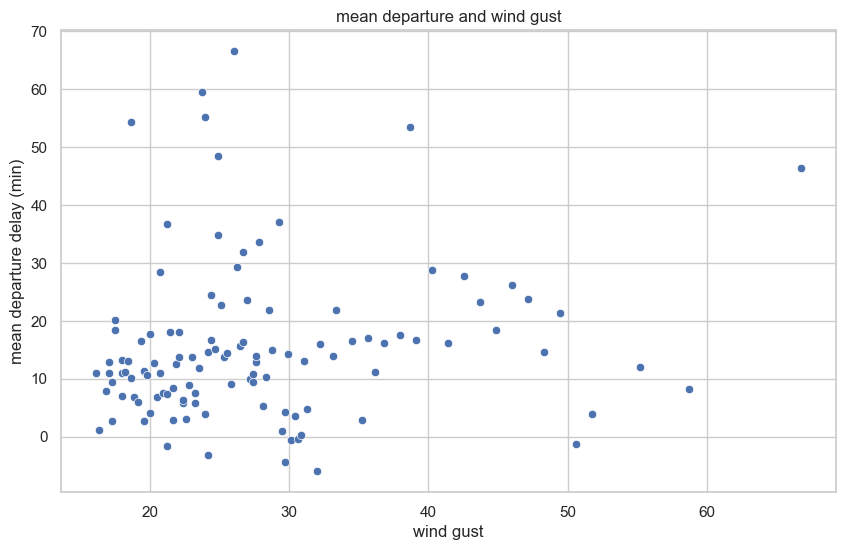

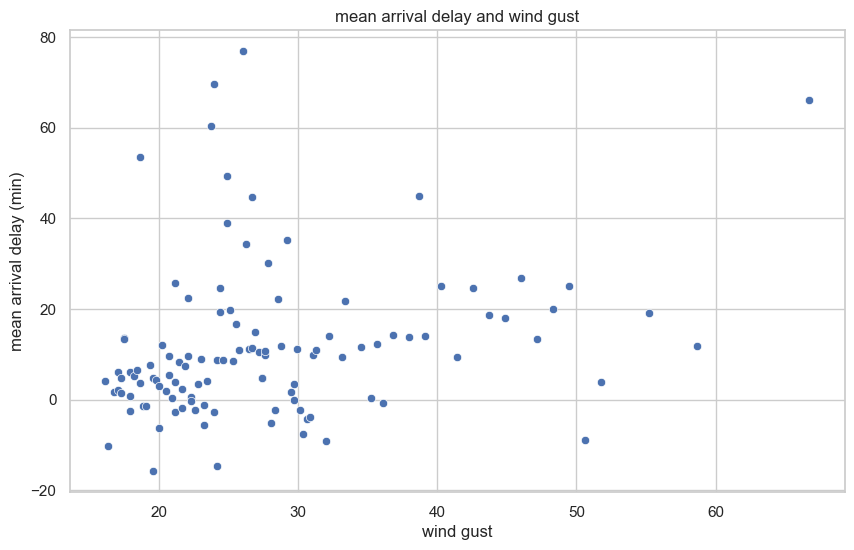

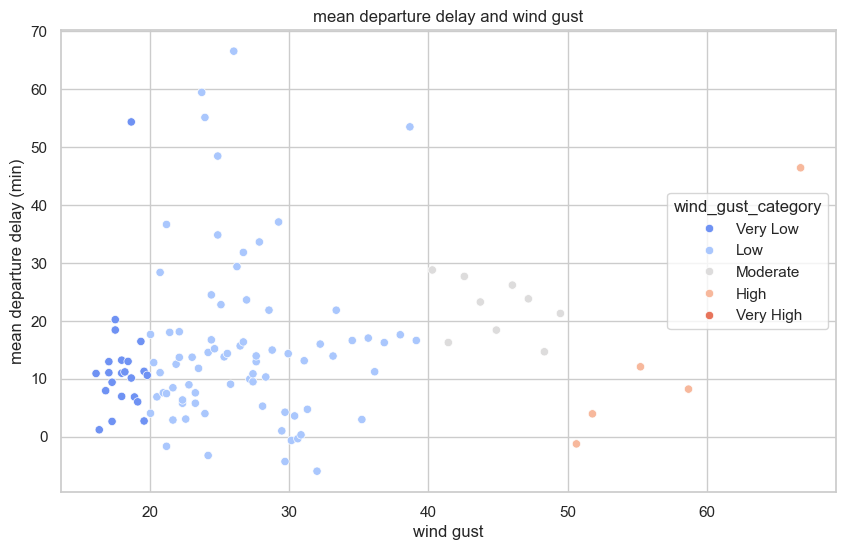

In [38]:
mean_dep_delay_wind_gust= df_flights_weather.groupby("wind_gust")["dep_delay"].mean().reset_index()
mean_arr_delay_wind_gust= df_flights_weather.groupby("wind_gust")["arr_delay"].mean().reset_index()
# plot wind gust and mean dep delay
plt.figure(figsize=(10, 6))
sns.scatterplot(x="wind_gust", y="dep_delay", data=mean_dep_delay_wind_gust)
plt.title('mean departure and wind gust')
plt.xlabel('wind gust')
plt.ylabel('mean departure delay (min)')
plt.show()

# plot wind gust and mean arrival delay
plt.figure(figsize=(10, 6))
sns.scatterplot(x='wind_gust', y='arr_delay', data=mean_arr_delay_wind_gust)
plt.title('mean arrival delay and wind gust')
plt.xlabel('wind gust')
plt.ylabel('mean arrival delay (min)')
plt.show()

# bin the wind gust to categories
wind_gust_bin = [-float('inf'), 20, 40, 50, 80, float('inf')]
wind_gust_label = ['Very Low', 'Low', 'Moderate', 'High', 'Very High']

mean_dep_delay_wind_gust['wind_gust_category'] = pd.cut(mean_dep_delay_wind_gust['wind_gust'], bins=wind_gust_bin, labels=wind_gust_label)

# plot wind guest and mean dep delay bin
plt.figure(figsize=(10, 6))
sns.scatterplot(x="wind_gust", y="dep_delay", data=mean_dep_delay_wind_gust, hue="wind_gust_category", palette="coolwarm")
plt.title('mean departure delay and wind gust')
plt.xlabel('wind gust')
plt.ylabel('mean departure delay (min)')
plt.legend(title='wind_gust_category')
plt.show()

df_flights_weather['wind_gust_category'] = pd.cut(df_flights_weather['wind_gust'], bins=wind_gust_bin, labels=wind_gust_label)

# Findings

There seems to be a pattern between wind gust and delays. The higher the wind gust, is the higher the delay.

# Temperature

We can use the same method to find patterns between temperature and delay

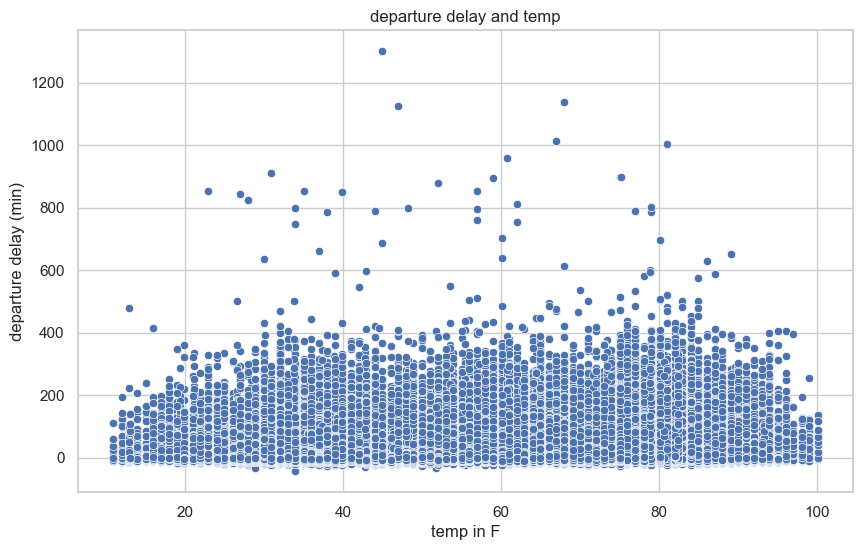

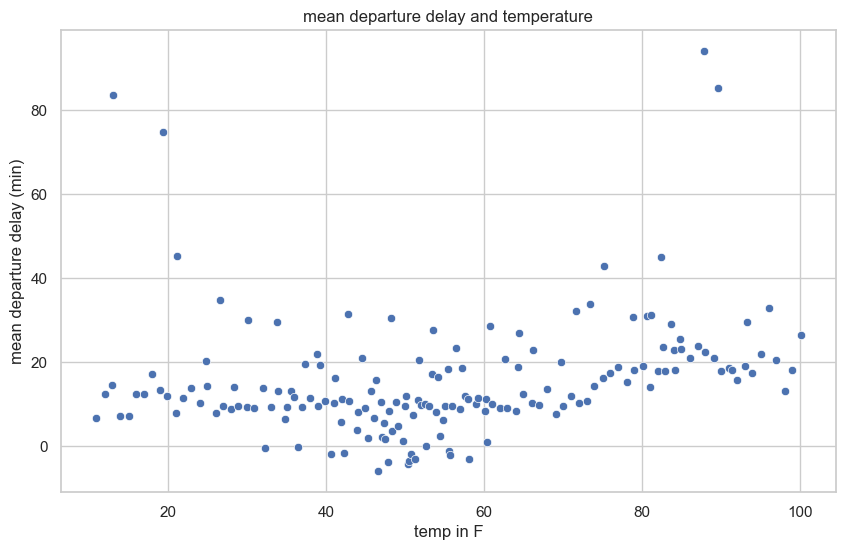

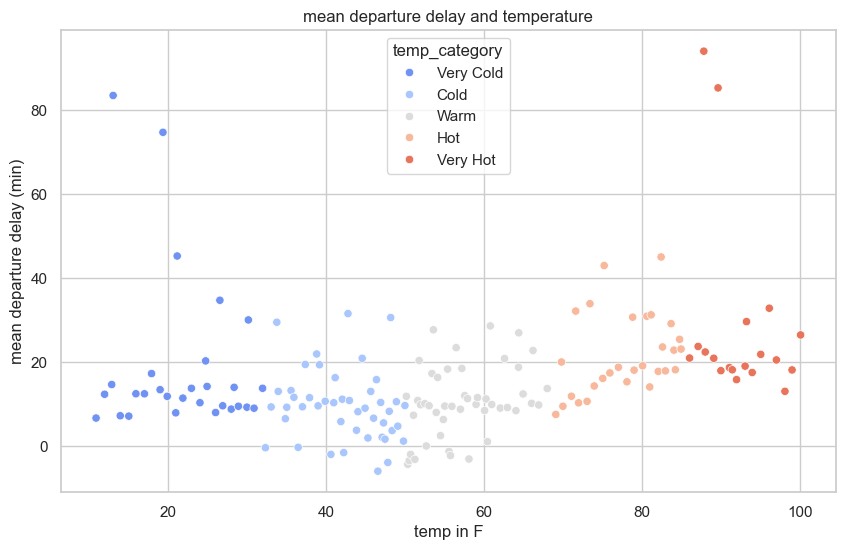

In [39]:
# plot the temp and departure delay
plt.figure(figsize=(10, 6))
sns.scatterplot(x="temp", y="dep_delay", data=df_flights_weather)
plt.title("departure delay and temp")
plt.xlabel("temp in F")
plt.ylabel('departure delay (min)')
plt.show()

mean_dep_delay_temp = df_flights_weather.groupby('temp')['dep_delay'].mean().reset_index()

# plot the temp and dep delay mean
plt.figure(figsize=(10, 6))
sns.scatterplot(x='temp', y='dep_delay', data=mean_dep_delay_temp)
plt.title('mean departure delay and temperature')
plt.xlabel('temp in F')
plt.ylabel('mean departure delay (min)')
plt.show()

# bin the temps to categories
bins = [-float('inf'), 32, 50, 68, 85, float('inf')]
labels = ['Very Cold', 'Cold', 'Warm', 'Hot', 'Very Hot']

mean_dep_delay_temp['temp_category'] = pd.cut(mean_dep_delay_temp['temp'], bins=bins, labels=labels)

# plot the bin of temp and dep_delay mean
plt.figure(figsize=(10, 6))
sns.scatterplot(x='temp', y='dep_delay', data=mean_dep_delay_temp, hue='temp_category', palette="coolwarm")
plt.title('mean departure delay and temperature')
plt.xlabel('temp in F')
plt.ylabel('mean departure delay (min)')
plt.legend(title='temp_category')
plt.show()

df_flights_weather['temp_category'] = pd.cut(df_flights_weather['temp'], bins=bins, labels=labels)

# Findings

Interestingly there is a quadratic pattern between very cold temperatures and very hot temperatures. For very Cold weather, delay times seem to increase. This is the same for very hot weawther. We can conclude the temperature impacts delays.

# Wind Direction

We can use the same method to find the pattern between wind direction and delay

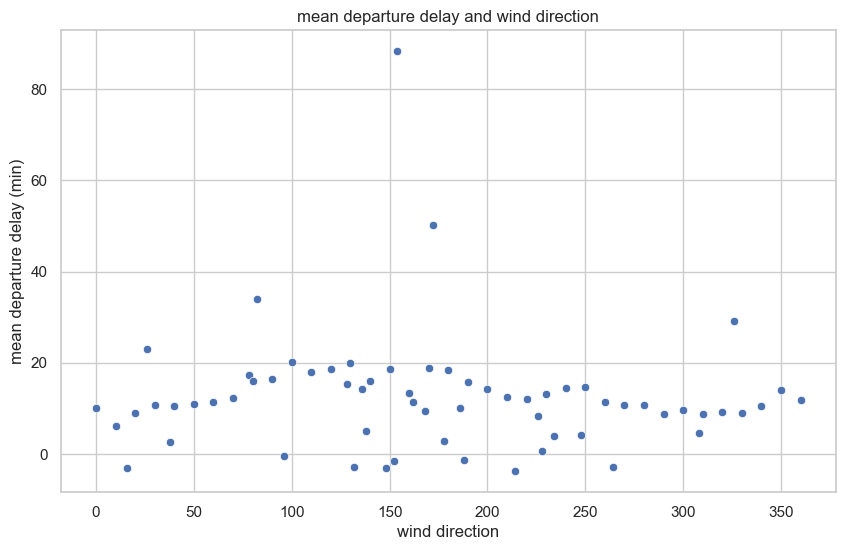

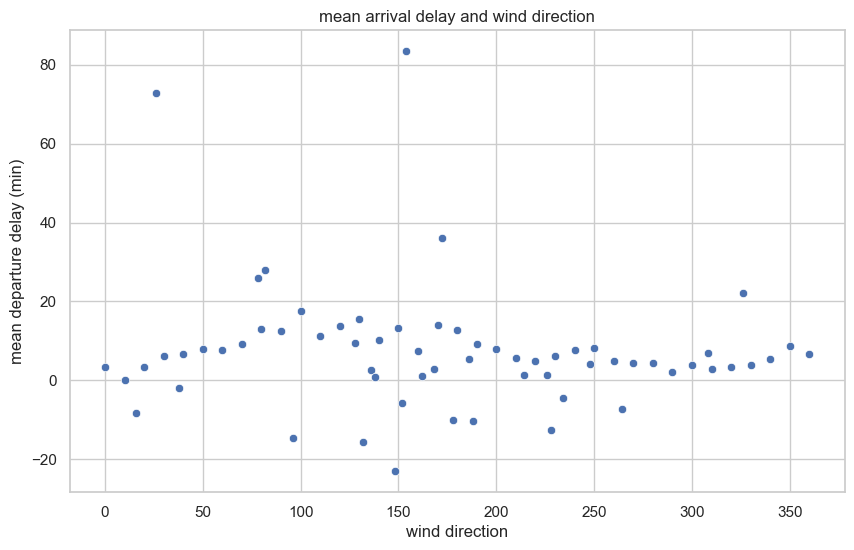

In [40]:
mean_dep_delay_wind_dir= df_flights_weather.groupby('wind_dir')['dep_delay'].mean().reset_index()
mean_arr_delay_wind_dir= df_flights_weather.groupby('wind_dir')['arr_delay'].mean().reset_index()
# plot the mean of departure delay and wind direction
plt.figure(figsize=(10, 6))
sns.scatterplot(x='wind_dir', y='dep_delay', data=mean_dep_delay_wind_dir)
plt.title('mean departure delay and wind direction')
plt.xlabel('wind direction')
plt.ylabel('mean departure delay (min)')
plt.show()

# plot the mean of arrival delay and wind direction
plt.figure(figsize=(10, 6))
sns.scatterplot(x='wind_dir', y='arr_delay', data=mean_arr_delay_wind_dir)
plt.title('mean arrival delay and wind direction')
plt.xlabel('wind direction')
plt.ylabel('mean departure delay (min)')
plt.show()



# Findings

There seems to be no pattern between wind direction and delay. Therefore we can conclude wind direction does not effect delay.

------------------
# Pressure

We can find the pattern between pressure and delay using the same method

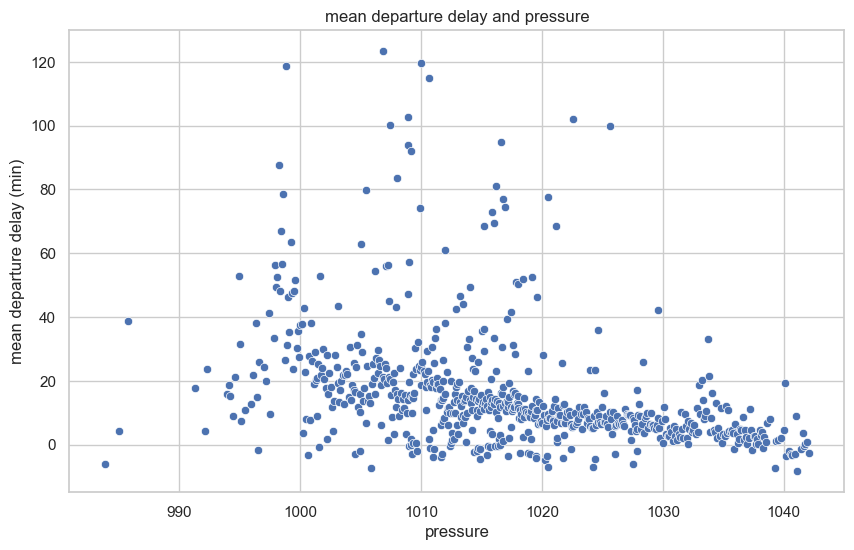

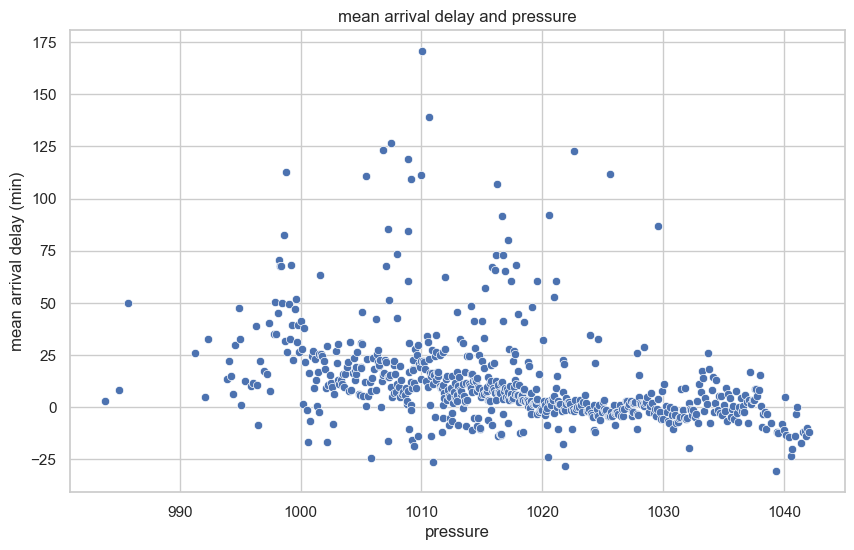

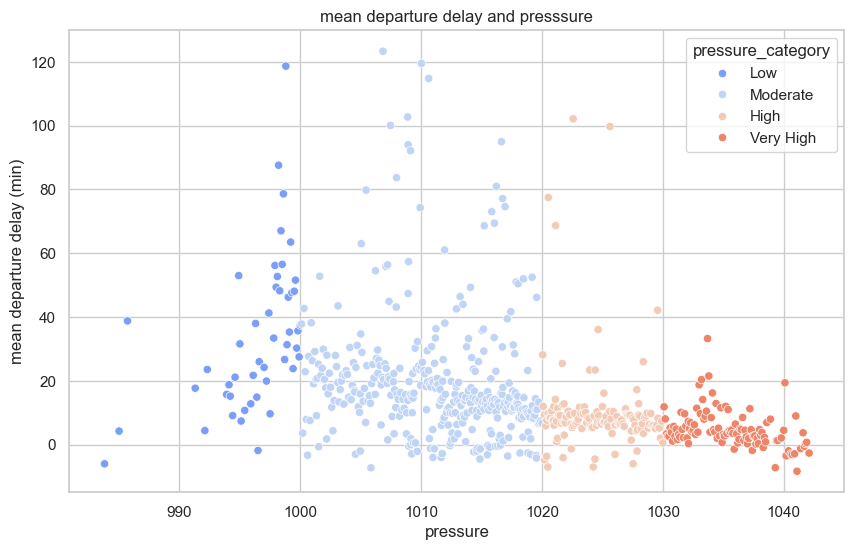

In [41]:
mean_dep_delay_pressure= df_flights_weather.groupby('pressure')['dep_delay'].mean().reset_index()
mean_arr_delay_pressure= df_flights_weather.groupby('pressure')['arr_delay'].mean().reset_index()

# plot the pressure and dep delay
plt.figure(figsize=(10, 6))
sns.scatterplot(x='pressure', y='dep_delay', data=mean_dep_delay_pressure)
plt.title('mean departure delay and pressure')
plt.xlabel("pressure")
plt.ylabel('mean departure delay (min)')
plt.show()

plt.figure(figsize=(10, 6))
sns.scatterplot(x="pressure", y="arr_delay", data=mean_arr_delay_pressure)
plt.title('mean arrival delay and pressure')
plt.xlabel('pressure')
plt.ylabel('mean arrival delay (min)')
plt.show()


# create the bins for pressure
bins = [-float('inf'), 1000, 1020, 1030, float('inf')]
labels = ['Low', 'Moderate', 'High', 'Very High']


mean_dep_delay_pressure['pressure_category'] = pd.cut(mean_dep_delay_pressure['pressure'], bins=bins, labels=labels)


# plot dep delay mean and the pressure bin
plt.figure(figsize=(10, 6))
sns.scatterplot(x='pressure', y='dep_delay', data=mean_dep_delay_pressure, hue='pressure_category', palette="coolwarm")
plt.title('mean departure delay and presssure')
plt.xlabel('pressure')
plt.ylabel("mean departure delay (min)")
plt.legend(title='pressure_category')
plt.show()

df_flights_weather['pressure_category'] = pd.cut(df_flights_weather['pressure'], bins=bins, labels=labels)

# Findings

There seems to be a linear correlation. Lower pressure values seems to cause higher delays. There are a few outlier plots with large delays but this is most likely caused due to other reasons such as congestion, other weather factors, etc.

--------------------------
# Conclusion

For most weather attributes, the scatter plots revealed that they impact delays. 

Furhter analysis such as statistical test or machine learning could provide deeper insights into how specific carriers, origins, or destinations affect delays.

Additionally, we identified seasonal trends, with summer and winter months experiencing higher delays, likely due to weather-related events, holidays, and with summer being vacation time.

 Peak delay hours were observed between 10:00 AM and 7:00 PM, indicating potential air congestion during these times. Outlier detection using the IQR method highlighted significant outliers in features like departure and arrival delays, which may require further investigation or preprocessing.

 Overall, this analysis highlights the importance of departure and arrival delays in predicting total delays and sets the stage for more advanced modeling techniques to better understand and mitigate flight delays.

-------------

# Save the CSV File with the new columns

In [ ]:
import os

df_flights_weather = df_flights_weather[df_flights_weather['air_time'] > 0]

def categorize_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    elif month in [9, 10, 11]:
        return 'Fall'

df_flights_weather['season'] = df_flights_weather['month'].apply(categorize_season)

file_path = 'feature_engineering.csv'
if not os.path.exists(file_path):
    df_flights_weather.to_csv(file_path, index=False)
    print(f"File '{file_path}' saved successfully.")
else:
    print(f"File '{file_path}' already exists. No changes were made.")


File 'feature_engineering.csv' already exists. No changes were made.


# Machine Learning Models

The objective of our models is to predict the amount of time in minutes that a flight will be delayed. From there we can take corrective action if a flight is delayed significantly. Our goal is to have the best performing model that has the lowest RMSE (in minutes)

In [43]:
import pandas as pd

df = pd.read_csv('feature_engineering.csv')

print("Columns in the dataset:")
print(df.columns.tolist())

Columns in the dataset:
['id', 'year', 'month', 'day', 'dep_time', 'sched_dep_time', 'dep_delay', 'arr_time', 'sched_arr_time', 'arr_delay', 'carrier', 'flight', 'tailnum', 'origin', 'dest', 'air_time', 'distance', 'hour', 'minute', 'time_hour_x', 'name', 'missing_count', 'flight_status', 'total_delay', 'date', 'is_holiday', 'season', 'dep_time_category', 'arr_time_category', 'temp', 'dewp', 'humid', 'wind_dir', 'wind_speed', 'wind_gust', 'precip', 'pressure', 'visib', 'time_hour_y', 'precip_category', 'visib_category', 'wind_speed_category', 'wind_gust_category', 'temp_category', 'pressure_category']


# Feature Engineering

This will put each date on a unit circle to help maintain the cyclic features. We also encode the numeric and categorical attributes to be trained by each model.

In [ ]:
import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

# Cyclical Encoding for day and month
def convert_to_circle(column, max_value):
    """Convert a column to cyclical features using sine and cosine."""
    angle = 2 * np.pi * (column - 1) / max_value 
    x = np.cos(angle)  # x-coordinate on the unit circle
    y = np.sin(angle)  # y-coordinate on the unit circle
    return x, y

# Time Hour to datetime
df['time_hour_x'] = pd.to_datetime(df['time_hour_x'])

df['hour'] = df['time_hour_x'].dt.hour
df['day_of_week'] = df['time_hour_x'].dt.dayofweek 
df['month'] = df['time_hour_x'].dt.month

# Cyclical encoding to day_of_week and month
df['day_x'], df['day_y'] = convert_to_circle(df['day_of_week'], 7) 
df['month_x'], df['month_y'] = convert_to_circle(df['month'], 12)  

# Numerical attributes for modeling
categorical_features =  ['carrier', 'origin', 'dest', 'flight_status', 'tailnum', 'is_holiday', 'season']

# Numerical Attributes for modeling
numerical_features = ['dep_time', 'arr_time', 'air_time', 'distance', 'hour', 'day_x', 'month_x', 'temp', 'wind_speed', 'wind_gust', 'precip', 'pressure', 'visib']

# Apply OneHotEncoder to categorical_features
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)  
    ],
    remainder='passthrough' 
)


# X contains only the features we want, Y is total_delay
X = df[categorical_features + numerical_features]
y = df['total_delay'] 

# Apply preprocessing
X_preprocessed = preprocessor.fit_transform(X)

# Print preprocessed data
print("\nShape of preprocessed features (X_preprocessed):", X_preprocessed.shape)
print("\nFirst 5 rows of preprocessed features:")
print(X_preprocessed[:5]) 


Shape of preprocessed features (X_preprocessed): (325819, 4180)

First 5 rows of preprocessed features:
  (0, 11)	1.0
  (0, 16)	1.0
  (0, 62)	1.0
  (0, 123)	1.0
  (0, 303)	1.0
  (0, 4162)	1.0
  (0, 4166)	1.0
  (0, 4167)	517.0
  (0, 4168)	830.0
  (0, 4169)	227.0
  (0, 4170)	1400.0
  (0, 4171)	5.0
  (0, 4172)	1.0
  (0, 4173)	1.0
  (0, 4174)	39.02
  (0, 4175)	12.65858
  (0, 4176)	17.261699999999998
  (0, 4178)	1011.9
  (0, 4179)	10.0
  (1, 11)	1.0
  (1, 18)	1.0
  (1, 62)	1.0
  (1, 123)	1.0
  (1, 647)	1.0
  (1, 4162)	1.0
  :	:
  (3, 4173)	1.0
  (3, 4174)	39.02
  (3, 4175)	14.96014
  (3, 4176)	24.16638
  (3, 4178)	1012.1
  (3, 4179)	10.0
  (4, 4)	1.0
  (4, 18)	1.0
  (4, 23)	1.0
  (4, 123)	1.0
  (4, 2783)	1.0
  (4, 4162)	1.0
  (4, 4166)	1.0
  (4, 4167)	554.0
  (4, 4168)	812.0
  (4, 4169)	116.0
  (4, 4170)	762.0
  (4, 4171)	6.0
  (4, 4172)	1.0
  (4, 4173)	1.0
  (4, 4174)	39.92
  (4, 4175)	16.11092
  (4, 4176)	23.0156
  (4, 4178)	1011.7
  (4, 4179)	10.0


# Statistics of Total Delay

In [45]:
print("Target variable (total_delay) statistics:")
print(df['total_delay'].describe())

Target variable (total_delay) statistics:
count    325819.000000
mean         19.434051
std          82.924651
min        -100.000000
25%         -21.000000
50%          -6.000000
75%          22.000000
max        2573.000000
Name: total_delay, dtype: float64


In [46]:
# Columns
print("Columns in X_preprocessed:")
print(preprocessor.get_feature_names_out())

assert 'total_delay' not in preprocessor.get_feature_names_out()

Columns in X_preprocessed:
['cat__carrier_9E' 'cat__carrier_AA' 'cat__carrier_AS' ...
 'remainder__precip' 'remainder__pressure' 'remainder__visib']


# Linear Regression

We train using the linear regression model with the encoded attributes by splitting 70% to train data and 30% to test data. We also get the RMSE value to see if the model is sufficient

In [47]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np

# Data split
X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y, test_size=0.3, random_state=42)

# Train
model = LinearRegression()
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# RMSE evaluate
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error (RMSE):", rmse)

Root Mean Squared Error (RMSE): 75.81179080324202


The results show that on average, predictions deviate from actual delays by ~76 minutes.

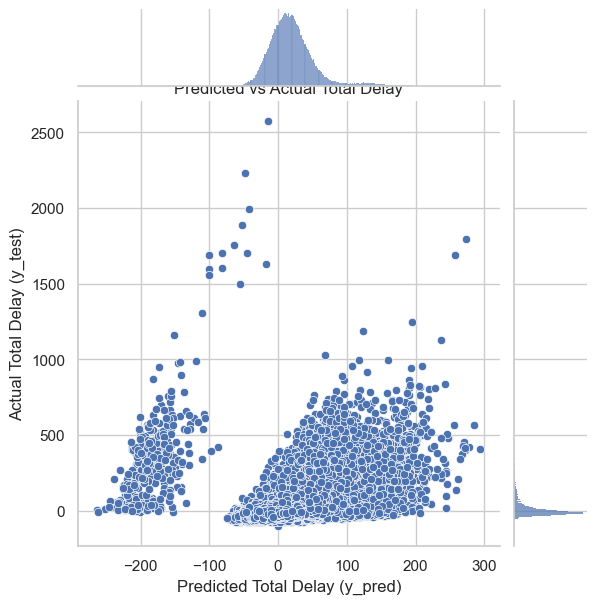

In [48]:
import seaborn as sns
import matplotlib.pyplot as plt

def sns_jointplot(y_pred, y_test):
    sns.jointplot(x=y_pred, y=y_test, kind='scatter')
    plt.xlabel('Predicted Total Delay (y_pred)')
    plt.ylabel('Actual Total Delay (y_test)')
    plt.title('Predicted vs Actual Total Delay')
    plt.show()

sns_jointplot(y_pred, y_test)

Insights:

Points should ideally align close to the diagonal (y=x).

Outliers: High delays (>200 mins) are likely underpredicted (could be due to the linear model's skewed targets).

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# Poisson Regression Attempt with Exposure

In [49]:
import numpy as np
from sklearn.linear_model import PoissonRegressor
from sklearn.metrics import mean_squared_error
from time import time

def poisson_with_exposure(X_train, y_train, X_test, y_test, exposure_train, exposure_test):
    
    start_time = time()
    
    y_train_np = np.asarray(y_train).ravel()
    X_train_np = X_train.toarray() if hasattr(X_train, 'toarray') else np.asarray(X_train)
    X_test_np = X_test.toarray() if hasattr(X_test, 'toarray') else np.asarray(X_test)
    
    # Negative values
    offset = np.abs(y_train_np.min()) + 1 if y_train_np.min() < 0 else 0
    y_train_adj = y_train_np + offset
    
    exposure_train = np.asarray(exposure_train).ravel().clip(min=1e-6)
    exposure_test = np.asarray(exposure_test).ravel().clip(min=1e-6)
    
    
    print("Fitting Poisson model with exposure...")
    model = PoissonRegressor(
        alpha=0,
        max_iter=200,
        tol=1e-4,
        fit_intercept=True 
    )
    
    # Fit
    model.fit(X_train_np, y_train_adj, sample_weight=exposure_train)
    
    # Predict
    y_pred = model.predict(X_test_np) * exposure_test - offset
    
    # Metrics
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    print(f"RMSE: {rmse:.2f}")
    print(f"Training time: {time()-start_time:.1f} seconds")
    
    return y_pred

exposure_train = df.loc[y_train.index, 'distance'].values
exposure_test = df.loc[y_test.index, 'distance'].values

y_pred = poisson_with_exposure(
    X_train, y_train, 
    X_test, y_test,
    exposure_train, exposure_test
)

Fitting Poisson model with exposure...


c:\Users\Eric\miniconda3\Lib\site-packages\sklearn\linear_model\_linear_loss.py:295: RuntimeWarning: invalid value encountered in matmul
  grad[:n_features] = X.T @ grad_pointwise + l2_reg_strength * weights


RMSE: 144513.66
Training time: 15.1 seconds


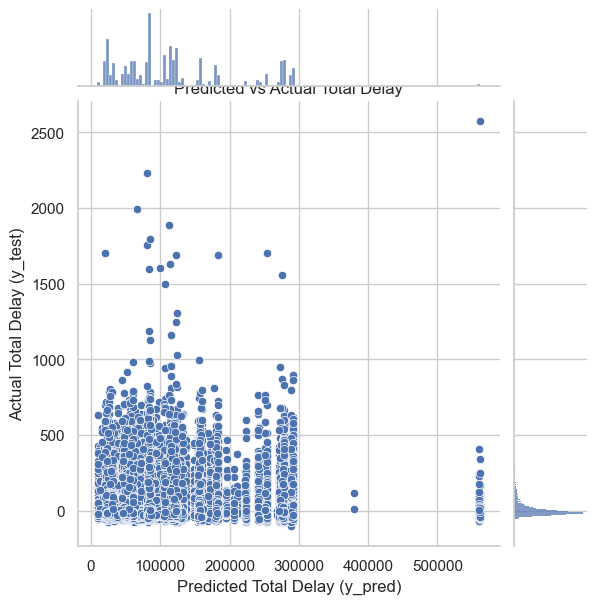

In [50]:
sns_jointplot(y_pred, y_test)

# Invalid Poisson Assumptions:

Poisson requires integer counts, but delays can be negative.

Even after offset adjustment (y_train_adj = y_train + offset), the distribution remains unsuitable.

# Exposure Misapplication:

Using distance as exposure incorrectly assumes delay scales linearly with distance.

Runtime warnings indicate numerical instability during fitting.

Performance Degradation:

RMSE increased from 75.81 (Linear Regression) to 144,513.66.

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# Random Forest Model

We train a random forest reggressor using the same train data and test data from previously.

In [51]:
from sklearn.ensemble import RandomForestRegressor

# Random Forest Regressor
rf_model = RandomForestRegressor(
    n_estimators=10, 
    max_depth=10,    
    random_state=42, 
    n_jobs=-1        
)

# Train
rf_model.fit(X_train, y_train)

# Predictions
y_pred_rf = rf_model.predict(X_test)

# RMSE evaluate
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
print("Random Forest RMSE:", rmse_rf)

Random Forest RMSE: 37.84741409299429


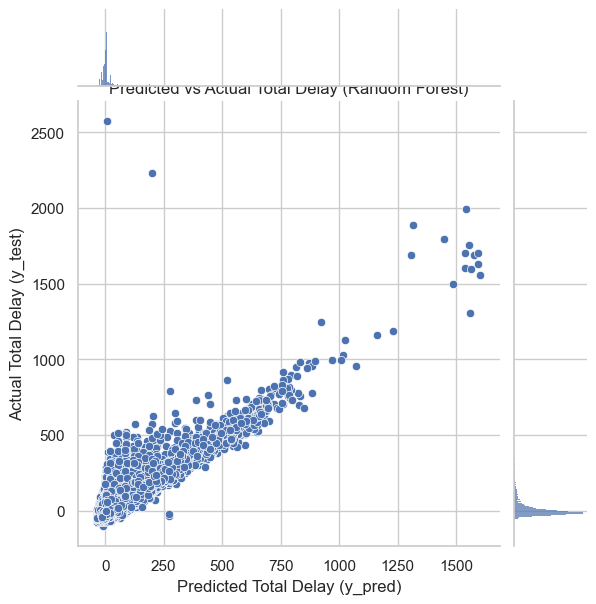

In [52]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot function
def sns_jointplot(y_pred, y_test, title):
    sns.jointplot(x=y_pred, y=y_test, kind='scatter')
    plt.xlabel('Predicted Total Delay (y_pred)')
    plt.ylabel('Actual Total Delay (y_test)')
    plt.title(title)
    plt.show()

    # Random forest plot
sns_jointplot(y_pred_rf, y_test, title='Predicted vs Actual Total Delay (Random Forest)')

# Important Points to Note:

 tighter clustering than linear regression along the diagonal (y=x line).

 Although still underestimated, there is a better prediction for extreme delays (>500 minutes).

 A minor bias to underestimate significant delays, which is typical of tree-based models with skewed objectives.

 

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

# XGBoost Regression Implementation

We will jump to XGBoost and see how different the RMSE is, to save time on finding out best model that predicts `total_delay`.

In [53]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

# XGBRegressor
xgb_model = XGBRegressor(
    n_estimators=100, 
    max_depth=6,      
    learning_rate=0.1, 
    random_state=42,   
    n_jobs=-1         
)

# Train
xgb_model.fit(X_train, y_train)

# Prediction
y_pred_xgb = xgb_model.predict(X_test)

# RMSE evaluate
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
print("XGBoost RMSE:", rmse_xgb)

XGBoost RMSE: 28.438963300620795


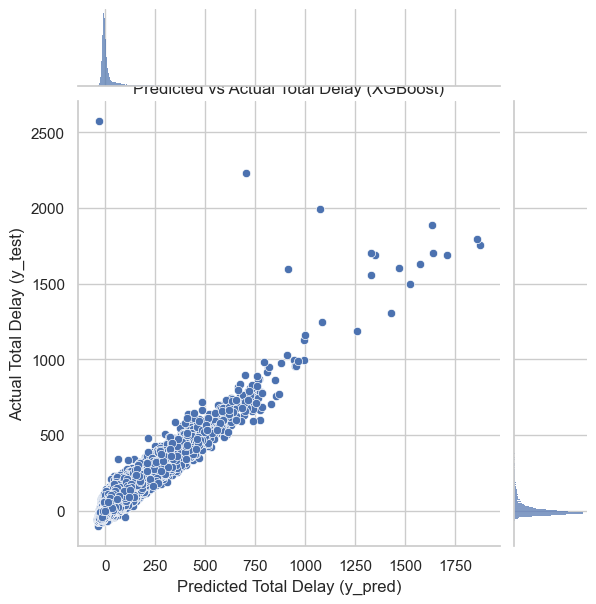

In [54]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot function
def sns_jointplot(y_pred, y_test, title):
    sns.jointplot(x=y_pred, y=y_test, kind='scatter')
    plt.xlabel('Predicted Total Delay (y_pred)')
    plt.ylabel('Actual Total Delay (y_test)')
    plt.title(title)
    plt.show()

# Plot for XGBoost
sns_jointplot(y_pred_xgb, y_test, title='Predicted vs Actual Total Delay (XGBoost)')

Main Enhancements:

clumping along the y=x line more tightly than Random Forest

Improved management of intermediate delays (between 100 and 500 minutes)

Extremely long delays are still held back on predicted predictions compared to actual (>1000 minutes)

Can we improve this model based on the data? Poisson Distribution with XGBoost?

# Poisson XGBoost Implementation

In [55]:
offset = np.abs(np.min(y_train)) + 1 
y_train_adj = y_train + offset
y_test_adj = y_test + offset  

# XGBoost with Poisson
xgb_poisson = XGBRegressor(
    objective='count:poisson',
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    random_state=42,
    n_jobs=-1
)

xgb_poisson.fit(X_train, y_train_adj)

y_pred_poisson = xgb_poisson.predict(X_test) - offset  

# Evaluate
rmse = np.sqrt(mean_squared_error(y_test, y_pred_poisson))
print(f"RMSE: {rmse:.2f}")

RMSE: 35.58


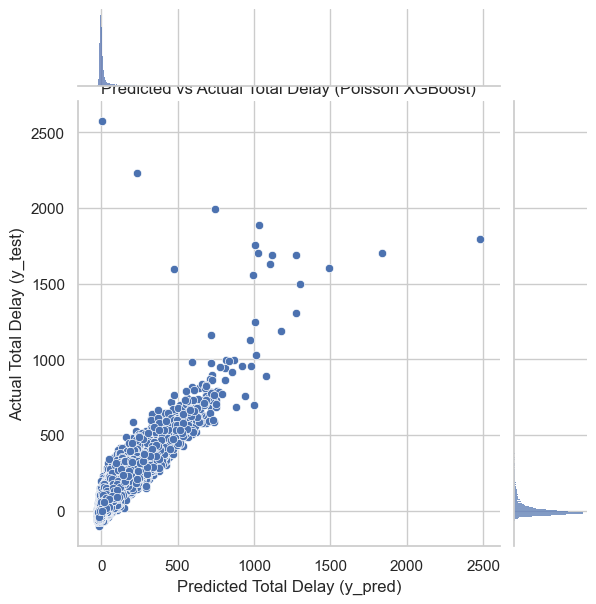

In [56]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot function
def sns_jointplot(y_pred, y_test, title):
    sns.jointplot(x=y_pred, y=y_test, kind='scatter')
    plt.xlabel('Predicted Total Delay (y_pred)')
    plt.ylabel('Actual Total Delay (y_test)')
    plt.title(title)
    plt.show()

# Plot Poisson XGBoost
sns_jointplot(y_pred_poisson, y_test, title='Predicted vs Actual Total Delay (Poisson XGBoost)')

Why was it worse?

- The count data rule violated the delays which are continuous.
- This is because we have negative values and other occurences in the data that do not support Poisson Distribution.

Can we try anything else then?

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# Two-Stage Random Forest Model
Concept:

- Classifies flights as either:

    - Early (delay < 0)

    - Delayed (delay > 0)

And then it predicts delay magnitude using specialized regressors for each specific group.

Training classifier...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.6s finished


Training early-flight regressor on 131339 samples...
Training delayed-flight regressor on 94021 samples...
Making predictions...


[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  50 out of  50 | elapsed:    0.0s finished



Two-Stage RF RMSE: 84.80
Total runtime: 43.0 seconds


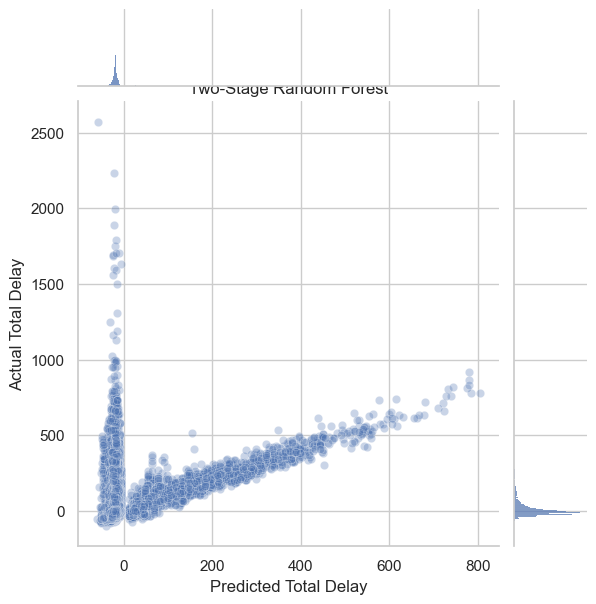

In [57]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import mean_squared_error
import time


start_time = time.time()

y_train_class = np.sign(y_train) 
classifier = RandomForestClassifier(
    n_estimators=50,  
    max_depth=10,
    random_state=42,
    n_jobs=-1,
    verbose=1  
)
print("Training classifier...")
classifier.fit(X_train, y_train_class)


early_mask = (y_train < 0)
reg_early = RandomForestRegressor(
    n_estimators=50,
    max_depth=10,
    random_state=42,
    n_jobs=-1
)
print(f"Training early-flight regressor on {sum(early_mask)} samples...")
if sum(early_mask) > 0:  # Only fit if early flights exist
    reg_early.fit(X_train[early_mask], y_train[early_mask])

# Delayed flights (positive delays)
delayed_mask = (y_train > 0)
reg_delayed = RandomForestRegressor(
    n_estimators=50,
    max_depth=10,
    random_state=42,
    n_jobs=-1
)
print(f"Training delayed-flight regressor on {sum(delayed_mask)} samples...")
reg_delayed.fit(X_train[delayed_mask], y_train[delayed_mask])


print("Making predictions...")
y_class_pred = classifier.predict(X_test)
y_pred = np.zeros(len(y_test))  


early_test_mask = (y_class_pred == -1)
delayed_test_mask = (y_class_pred == 1)

if sum(early_test_mask) > 0:
    y_pred[early_test_mask] = reg_early.predict(X_test[early_test_mask])
y_pred[delayed_test_mask] = reg_delayed.predict(X_test[delayed_test_mask])


rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"\nTwo-Stage RF RMSE: {rmse:.2f}")
print(f"Total runtime: {time.time() - start_time:.1f} seconds")


def sns_jointplot(y_pred, y_test, title):
    import seaborn as sns
    import matplotlib.pyplot as plt
    sns.jointplot(x=y_pred, y=y_test, kind='scatter', alpha=0.3)
    plt.xlabel('Predicted Total Delay')
    plt.ylabel('Actual Total Delay')
    plt.title(title)
    plt.show()

sns_jointplot(y_pred, y_test, "Two-Stage Random Forest")

Results:
- RMSE is too high compared to other models
- there is a visual misalignment in the joint plot.
- The results show potential earlier flights are being misclassified, hence the wrong regressor is being used
- The results also show later flights slightly are also being predicted slightly off, meaning the magnitude classification is off as well

So what else can we try??

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# Implementation for Linear Support Vector Regression (SVR)

SVR is the regression variant of SVM which predicts continuous values instead of classes.

Training Linear SVM...
[LibLinear]

c:\Users\Eric\miniconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(



Linear SVM RMSE: 94.48
Runtime: 66.1 seconds


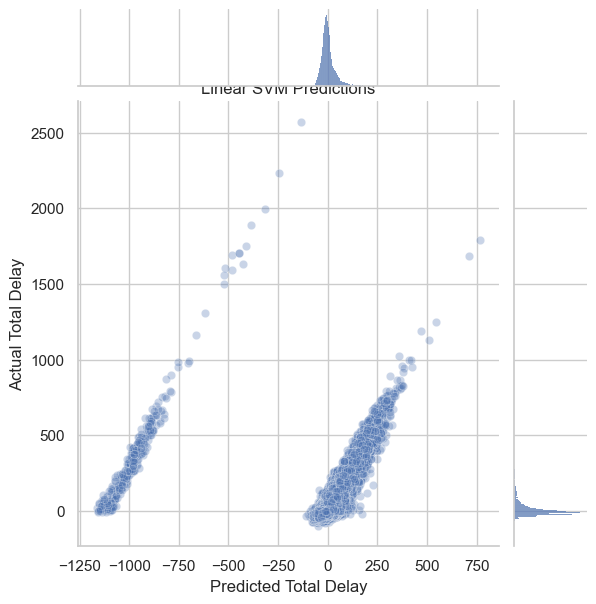

In [58]:
from sklearn.svm import LinearSVR
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import time

start_time = time.time()

svm_model = make_pipeline(
    StandardScaler(with_mean=False), 
    LinearSVR(
        C=1.0,
        epsilon=0.1,              
        max_iter=1000,             
        random_state=42,
        verbose=1                 
    )
)

# Train
print("Training Linear SVM...")
svm_model.fit(X_train, y_train)

# Predict
y_pred_svm = svm_model.predict(X_test)

# Evaluate
rmse_svm = np.sqrt(mean_squared_error(y_test, y_pred_svm))
print(f"\nLinear SVM RMSE: {rmse_svm:.2f}")
print(f"Runtime: {time.time() - start_time:.1f} seconds")

# Plot
sns_jointplot(y_pred_svm, y_test, "Linear SVM Predictions")

SVR was extremely poor because we ended up with too many features after one-hot encoding. The data is most likely too large and spread out for this model. 

To confirm this issue, we will attempt RBF Kernel Support Vector Regression.

Training RBF SVM...
[LibSVM]

c:\Users\Eric\miniconda3\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(



RBF SVM RMSE: 239.61
Training time: 24.3 seconds


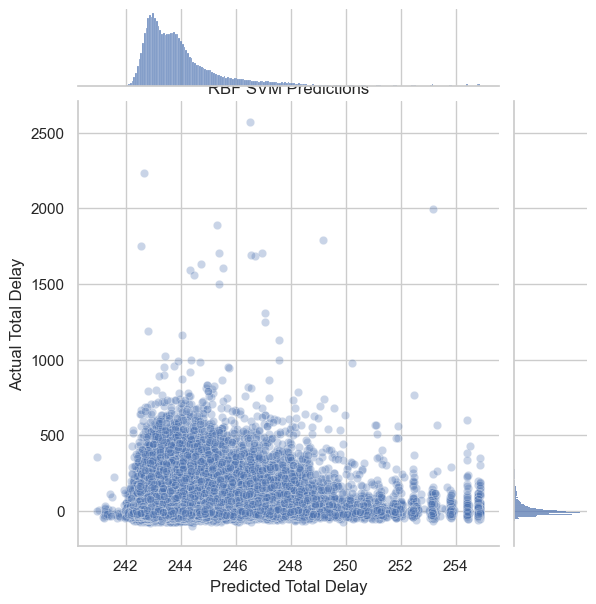

In [59]:
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import numpy as np
import time

start_time = time.time()

svm_model = make_pipeline(
    StandardScaler(with_mean=False),  
    SVR(
        kernel='rbf',
        C=10.0,                    
        epsilon=0.1,               
        gamma='scale',             
        cache_size=1000,           
        max_iter=500,              
        verbose=True               
    )
)

print("Training RBF SVM...")
svm_model.fit(X_train, y_train)

# Predict and evaluate
y_pred_svm = svm_model.predict(X_test)
rmse_svm = np.sqrt(mean_squared_error(y_test, y_pred_svm))

print(f"\nRBF SVM RMSE: {rmse_svm:.2f}")
print(f"Training time: {time.time() - start_time:.1f} seconds")

# Plot results
def sns_jointplot(y_pred, y_test, title):
    import seaborn as sns
    import matplotlib.pyplot as plt
    sns.jointplot(x=y_pred, y=y_test, kind='scatter', alpha=0.3)
    plt.xlabel('Predicted Total Delay')
    plt.ylabel('Actual Total Delay')
    plt.title(title)
    plt.show()

sns_jointplot(y_pred_svm, y_test, "RBF SVM Predictions")

As expected, the results worsenned, and their appears to be no comprehensible pattern using SVR models, due to the data.

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# Cross Validation Comparisons Between Models

Hitting a hard spot in the project, we decided to proceed with the models that we have and attempt cross validation. Some key attributes:
- used 5-fold CV to aid with data splits
- `n_jobs=-1` to use full CPU utilization and increase speed. (on my laptop it took 202 minutes to complete)

In [60]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import make_scorer
import numpy as np
import warnings

def evaluate_model(model, X, y, model_type='standard', n_folds=5):
    if model_type == 'standard':
        rmse_scores = -cross_val_score(model, X, y, 
                                     cv=n_folds,
                                     scoring='neg_root_mean_squared_error',
                                     n_jobs=-1)
    elif model_type in ['poisson', 'poisson_exposure']:
        kf = KFold(n_folds, shuffle=True, random_state=42)
        rmse_scores = []
        
        for train_idx, test_idx in kf.split(X):
            X_train_fold, X_test_fold = X.iloc[train_idx], X.iloc[test_idx]
            y_train_fold, y_test_fold = y.iloc[train_idx], y.iloc[test_idx]
            
            if model_type == 'poisson_exposure':
            
                exposure_train = np.log(X_train_fold['N_trains'] + 1e-4)
                exposure_test = np.log(X_test_fold['N_trains'] + 1e-4)
                X_train_fold = X_train_fold.drop(columns=['N_trains'])
                X_test_fold = X_test_fold.drop(columns=['N_trains'])
                model.set_params(offset=exposure_train)
            
            model.fit(X_train_fold, y_train_fold)
            y_pred = model.predict(X_test_fold)
            rmse_scores.append(np.sqrt(mean_squared_error(y_test_fold, y_pred)))
    
    return {
        'mean_rmse': np.mean(rmse_scores),
        'std_rmse': np.std(rmse_scores),
        'all_scores': rmse_scores
    }

In [61]:
# Linear Regression
from sklearn.linear_model import LinearRegression
lr_results = evaluate_model(LinearRegression(), X_train, y_train)

# Random Forest
from sklearn.ensemble import RandomForestRegressor
rf_results = evaluate_model(RandomForestRegressor(n_estimators=100, random_state=42), 
                           X_train, y_train)

# XGBoost
from xgboost import XGBRegressor
xgb_results = evaluate_model(XGBRegressor(objective='reg:squarederror'), 
                            X_train, y_train)

# XGBoost Poisson
xgb_poisson = XGBRegressor(objective='count:poisson')
offset = np.abs(np.min(y_train)) + 1
xgb_poisson_results = evaluate_model(xgb_poisson, X_train, y_train + offset)
xgb_poisson_results['mean_rmse'] -= offset 

# SVM
from sklearn.svm import LinearSVR
svm_results = evaluate_model(LinearSVR(max_iter=1000), X_train, y_train)

In [62]:
results = {
    'Linear Regression': lr_results,
    'Random Forest': rf_results,
    'XGBoost': xgb_results,
    'XGBoost Poisson': xgb_poisson_results,
    'Linear SVM': svm_results
}

for name, res in results.items():
    print(f"{name}:")
    print(f"  Mean RMSE: {res['mean_rmse']:.2f}")
    print(f"  Std RMSE: {res['std_rmse']:.2f}")
    print(f"  All scores: {[f'{x:.2f}' for x in res['all_scores']]}")
    print()

Linear Regression:
  Mean RMSE: 75.14
  Std RMSE: 0.87
  All scores: ['76.78', '75.27', '74.36', '74.61', '74.68']

Random Forest:
  Mean RMSE: 20.84
  Std RMSE: 0.49
  All scores: ['21.81', '20.53', '20.50', '20.79', '20.57']

XGBoost:
  Mean RMSE: 23.72
  Std RMSE: 0.48
  All scores: ['23.39', '23.38', '24.66', '23.49', '23.67']

XGBoost Poisson:
  Mean RMSE: -68.16
  Std RMSE: 0.71
  All scores: ['28.62', '27.71', '28.60', '26.72', '27.56']

Linear SVM:
  Mean RMSE: 105.99
  Std RMSE: 43.60
  All scores: ['96.08', '192.34', '81.74', '80.18', '79.61']



The results reveal interesting results between Random Forest and XGBoost:
- RF is slightly better! It has consistently low variance across all the folds and better all time best RMSE.
- As expected Poisson XGBoost finished with a negative RMSE.
- Linear Regression and Linear SVM could not capture any complex patterns in the cleaned data.

Due to time constraints of the project, we chose to continue with hyper parameter tuning for the XGBoost model.

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# XGBoost Hyper Parameter Tuning Algorithm

- Uses Grid Search
- Validates with 5-fold cross validation
- `n_jobs=-1` for maximum CPU power
- Long runtime, so we printed the output of all the models to a csv file. 

In [63]:
from itertools import product
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score


# Cross Vlidation with n-folds
def regression_cv_xgb(model, X, y, n_folds=5):
    scores = -cross_val_score(model, X, y, 
                            cv=n_folds,
                            scoring='neg_root_mean_squared_error',
                            n_jobs=-1)
    return scores

# Grid search
def grid_search_xgb(params_grid, X, y, n_folds=5):
    best_score = float('inf')
    best_std = float('inf')
    best_params = None
    results = []

    for values in product(*params_grid.values()):
        params = dict(zip(params_grid.keys(), values))
        params.update({
            'objective': 'reg:squarederror',
            'random_state': 42,
            'n_jobs': -1
        })
        
        print(f"Testing params: {params}")
        
        model = XGBRegressor(**params)
        scores = regression_cv_xgb(model, X, y, n_folds=n_folds)
        
        mean_rmse = np.mean(scores)
        std_rmse = np.std(scores)

        results.append({
            "params": params,
            "mean_rmse": mean_rmse,
            "std_rmse": std_rmse,
            "scores": scores
        })

        print(f" Mean RMSE: {mean_rmse:.4f} (±{std_rmse:.4f})\n")

        if mean_rmse < best_score:
            best_score = mean_rmse
            best_params = params
            best_std = std_rmse
            print("=======NEW BEST======")

    results_df = pd.DataFrame(results)
    print(f"\n Best Params: {best_params}")
    print(f" Best RMSE mean: {best_score:.4f}")
    print(f" Best RMSE std: {best_std:.4f}")

    return best_params, results_df

# Hyperparameter grid
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9],
    'n_estimators': [100, 200, 300],
    'gamma': [0, 0.1, 0.2] 
}

# grid search
best_params, results_df = grid_search_xgb(param_grid, X_train, y_train, n_folds=5)

# results
results_df.to_csv("xgb_grid_search_results.csv", index=False)

# Model training with best parameters
final_model = XGBRegressor(**best_params)
final_model.fit(X_train, y_train)

# Evaluate on test set
y_pred = final_model.predict(X_test)
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"\n Final Test RMSE: {test_rmse:.4f}")

Testing params: {'learning_rate': 0.01, 'max_depth': 3, 'subsample': 0.7, 'colsample_bytree': 0.7, 'n_estimators': 100, 'gamma': 0, 'objective': 'reg:squarederror', 'random_state': 42, 'n_jobs': -1}
 Mean RMSE: 70.3928 (±0.7367)

=======NEW BEST======
Testing params: {'learning_rate': 0.01, 'max_depth': 3, 'subsample': 0.7, 'colsample_bytree': 0.7, 'n_estimators': 100, 'gamma': 0.1, 'objective': 'reg:squarederror', 'random_state': 42, 'n_jobs': -1}
 Mean RMSE: 70.3928 (±0.7367)

Testing params: {'learning_rate': 0.01, 'max_depth': 3, 'subsample': 0.7, 'colsample_bytree': 0.7, 'n_estimators': 100, 'gamma': 0.2, 'objective': 'reg:squarederror', 'random_state': 42, 'n_jobs': -1}
 Mean RMSE: 70.3928 (±0.7367)

Testing params: {'learning_rate': 0.01, 'max_depth': 3, 'subsample': 0.7, 'colsample_bytree': 0.7, 'n_estimators': 200, 'gamma': 0, 'objective': 'reg:squarederror', 'random_state': 42, 'n_jobs': -1}
 Mean RMSE: 64.7267 (±0.6592)

=======NEW BEST======
Testing params: {'learning_rate'

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# The End??
Now that we found our best model with the strongest parameters, we can reprint our encoding, best model, and attempt the final goal of the project...

In [64]:
import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

# Cyclical Encoding for day and month
def convert_to_circle(column, max_value):
    """Convert a column to cyclical features using sine and cosine."""
    angle = 2 * np.pi * (column - 1) / max_value 
    x = np.cos(angle)  # x-coordinate on the unit circle
    y = np.sin(angle)  # y-coordinate on the unit circle
    return x, y

# Time Hour to datetime
df['time_hour_x'] = pd.to_datetime(df['time_hour_x'])

df['hour'] = df['time_hour_x'].dt.hour
df['day_of_week'] = df['time_hour_x'].dt.dayofweek 
df['month'] = df['time_hour_x'].dt.month

# Apply cyclical encoding to day_of_week and month
df['day_x'], df['day_y'] = convert_to_circle(df['day_of_week'], 7) 
df['month_x'], df['month_y'] = convert_to_circle(df['month'], 12)  

# Numerical attributes for modeling
categorical_features =  ['carrier', 'origin', 'dest', 'flight_status', 'tailnum', 'is_holiday', 'season']

# Numerical Attributes for modeling
numerical_features = ['dep_time', 'arr_time', 'air_time', 'distance', 'hour', 'day_x', 'month_x', 'temp', 'wind_speed', 'wind_gust', 'precip', 'pressure', 'visib']

# Apply OneHotEncoder to categorical_features
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)  
    ],
    remainder='passthrough' 
)


# X contains only the features we want, Y is total_delay
X = df[categorical_features + numerical_features]
y = df['total_delay'] 

# Apply preprocessing
X_preprocessed = preprocessor.fit_transform(X)

# Print preprocessed data
print("\nShape of preprocessed features (X_preprocessed):", X_preprocessed.shape)
print("\nFirst 5 rows of preprocessed features:")
print(X_preprocessed[:5]) 


Shape of preprocessed features (X_preprocessed): (325819, 4180)

First 5 rows of preprocessed features:
  (0, 11)	1.0
  (0, 16)	1.0
  (0, 62)	1.0
  (0, 123)	1.0
  (0, 303)	1.0
  (0, 4162)	1.0
  (0, 4166)	1.0
  (0, 4167)	517.0
  (0, 4168)	830.0
  (0, 4169)	227.0
  (0, 4170)	1400.0
  (0, 4171)	5.0
  (0, 4172)	1.0
  (0, 4173)	1.0
  (0, 4174)	39.02
  (0, 4175)	12.65858
  (0, 4176)	17.261699999999998
  (0, 4178)	1011.9
  (0, 4179)	10.0
  (1, 11)	1.0
  (1, 18)	1.0
  (1, 62)	1.0
  (1, 123)	1.0
  (1, 647)	1.0
  (1, 4162)	1.0
  :	:
  (3, 4173)	1.0
  (3, 4174)	39.02
  (3, 4175)	14.96014
  (3, 4176)	24.16638
  (3, 4178)	1012.1
  (3, 4179)	10.0
  (4, 4)	1.0
  (4, 18)	1.0
  (4, 23)	1.0
  (4, 123)	1.0
  (4, 2783)	1.0
  (4, 4162)	1.0
  (4, 4166)	1.0
  (4, 4167)	554.0
  (4, 4168)	812.0
  (4, 4169)	116.0
  (4, 4170)	762.0
  (4, 4171)	6.0
  (4, 4172)	1.0
  (4, 4173)	1.0
  (4, 4174)	39.92
  (4, 4175)	16.11092
  (4, 4176)	23.0156
  (4, 4178)	1011.7
  (4, 4179)	10.0


In [65]:
# Getting feature names after preprocessing
cat_encoder = preprocessor.named_transformers_['cat']
cat_features = []

# One-encoded neames
for i, feature in enumerate(categorical_features):
    for category in cat_encoder.categories_[i]:
        cat_features.append(f"{feature}_{category}")

# Get numerical feature names 
num_features = numerical_features 

all_feature_names = cat_features + num_features
print(f"Total features: {len(all_feature_names)}")
print("Sample features:", all_feature_names[:5])

Total features: 4180
Sample features: ['carrier_9E', 'carrier_AA', 'carrier_AS', 'carrier_B6', 'carrier_DL']


<Figure size 1200x800 with 0 Axes>

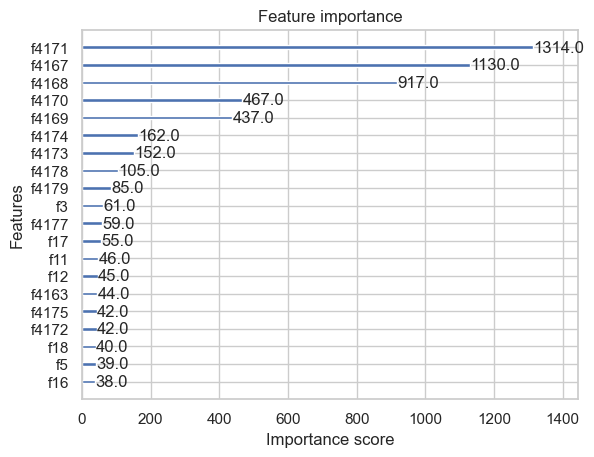


Hour feature importance: 0.1786


In [66]:
from xgboost import plot_importance
import matplotlib.pyplot as plt

# Train model
final_model = XGBRegressor(**{
    'objective': 'reg:squarederror',
    'learning_rate': 0.1,  
    'max_depth': 5,         
    'n_estimators': 200,
    'random_state': 42
})
final_model.fit(X_preprocessed, y)

plt.figure(figsize=(12, 8))
plot_importance(final_model, max_num_features=20)
plt.show()

# Check hour importance
hour_idx = all_feature_names.index('hour')
print(f"\nHour feature importance: {final_model.feature_importances_[hour_idx]:.4f}")

The findings before our final goal of the project:

Top 5 Predictive Features
1. Departure Time
2. Arrival Time
3. Air Time
4. Distance
5. Hour of Day

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# The True End!

Now that we can predict `total_delay' with a model we are satisifed with, we can aim to see if we can improve delays by creating a function to "shift" the `dep_time` values. 

We:
- identify the 5 worst flights with the highest amount of delays
- get the original flights, test them against the 1,2 and 3 hour earlier departures
- track the delay effects

In [67]:
from scipy import sparse

# Worst delays fron last 5 indices
worst_flight_indices = np.argsort(y_pred)[-5:]

# CSR format
X_preprocessed_csr = X_preprocessed.tocsr()

def optimize_flight(flight_idx, model, X_sparse, feature_names, hour_feature='hour', max_shift=3):
    """Optimizes departure time with proper sparse matrix handling"""
    # Get the row
    flight_row = X_sparse[flight_idx].toarray().flatten()
    hour_idx = feature_names.index(hour_feature)
    
    # Original prediction
    baseline_delay = model.predict(X_sparse[flight_idx:flight_idx+1])[0]
    best_time = flight_row[hour_idx]
    best_delay = baseline_delay
    results = []
    
    # Test shifts
    for shift in range(1, max_shift + 1):
        modified_row = flight_row.copy()
        modified_row[hour_idx] = max(0, flight_row[hour_idx] - shift)
        
        # Conert to sparse format
        current_delay = model.predict(sparse.csr_matrix(modified_row))[0]
        improvement = baseline_delay - current_delay
        
        results.append({
            'shift': shift,
            'new_hour': modified_row[hour_idx],
            'predicted_delay': current_delay,
            'improvement': improvement
        })
        
        if current_delay < best_delay:
            best_time = modified_row[hour_idx]
            best_delay = current_delay
    
    return {
        'flight_id': flight_idx,
        'original_hour': flight_row[hour_idx],
        'recommended_hour': best_time,
        'original_delay': baseline_delay,
        'best_delay': best_delay,
        'max_improvement': baseline_delay - best_delay,
        'options': pd.DataFrame(results)
    }

# Recommendations
recommendations = []
for idx in worst_flight_indices:
    rec = optimize_flight(idx, final_model, X_preprocessed_csr, all_feature_names)
    recommendations.append(rec)

# Report
report_data = []
for r in recommendations:
    report_data.append({
        'Flight ID': r['flight_id'],
        'Original Hour': r['original_hour'],
        'Recommended Hour': r['recommended_hour'],
        'Original Delay': f"{r['original_delay']:.1f} min",
        'Improved Delay': f"{r['best_delay']:.1f} min",
        'Improvement': f"{r['max_improvement']:.1f} min",
        'Options': f"{len(r['options'])} time shifts tested"
    })

print("Flight Delay Optimization Report")
print(pd.DataFrame(report_data).to_string(index=False))

# Details for best flight
if recommendations:
    best_flight = max(recommendations, key=lambda x: x['max_improvement'])
    print("\n Best Optimization Opportunity Details:")
    print(f"Flight ID: {best_flight['flight_id']}")
    print(f"Original Hour: {best_flight['original_hour']}")
    print(f"Recommended Hour: {best_flight['recommended_hour']}")
    print(f"Max Improvement: {best_flight['max_improvement']:.1f} minutes")
    print("\nAll tested time shifts:")
    print(best_flight['options'].to_string(index=False))

Flight Delay Optimization Report
 Flight ID  Original Hour  Recommended Hour Original Delay Improved Delay Improvement              Options
     97285           20.0              20.0        7.6 min        7.6 min     0.0 min 3 time shifts tested
     90131           16.0              16.0        3.0 min        3.0 min     0.0 min 3 time shifts tested
     77504           20.0              20.0       29.0 min       29.0 min     0.0 min 3 time shifts tested
     65766            8.0               8.0      -14.5 min      -14.5 min     0.0 min 3 time shifts tested
     63649           21.0              21.0      139.5 min      139.5 min     0.0 min 3 time shifts tested

 Best Optimization Opportunity Details:
Flight ID: 97285
Original Hour: 20.0
Recommended Hour: 20.0
Max Improvement: 0.0 minutes

All tested time shifts:
 shift  new_hour  predicted_delay  improvement
     1      19.0       112.275345  -104.711502
     2      18.0       216.568634  -209.004791
     3      17.0       353.60

In [68]:
print("\nHour value distribution in training data:")
print(pd.DataFrame(X_preprocessed[:, all_feature_names.index('hour')].toarray()).describe())

print("\nTesting hour modification impact:")
test_flight = X_preprocessed_csr[worst_flight_indices[0]].toarray().flatten()
hour_idx = all_feature_names.index('hour')
for shift in [1, 2, 3]:
    modified = test_flight.copy()
    modified[hour_idx] = max(0, test_flight[hour_idx] - shift)
    delay = final_model.predict(sparse.csr_matrix(modified))[0]
    print(f"Hour {modified[hour_idx]}: Predicted delay = {delay:.1f} min")


Hour value distribution in training data:
                   0
count  325819.000000
mean       13.134148
std         4.658191
min         5.000000
25%         9.000000
50%        13.000000
75%        17.000000
max        23.000000

Testing hour modification impact:
Hour 19.0: Predicted delay = 112.3 min
Hour 18.0: Predicted delay = 216.6 min
Hour 17.0: Predicted delay = 353.6 min


Unfortunately, earlier departures dont seem to decrease delays, but actually increase them.
based on the data, the mean of 13 means a peak of about 1PM. 5-8AM appear to have higher congestion, morning rush, colder temperatures but no direct proof of it affecting the flights besides our analysis (not enough values in the data to conclude this). 

Can we do more? Let's consider a larger time window on this outlier point.

In [ ]:
def debug_optimize_flight(flight_idx):
    flight_data = X_preprocessed_csr[flight_idx].toarray().flatten()
    hour_idx = all_feature_names.index('hour')
    
    print(f"\nDebugging Flight {flight_idx}:")
    print(f"Original hour: {flight_data[hour_idx]}")
    
    # Print most important features
    important_features = sorted(zip(final_model.feature_importances_, all_feature_names), reverse=True)[:10]
    print("\nTop 10 important features:")
    for imp, name in important_features:
        if name in all_feature_names:
            idx = all_feature_names.index(name)
            print(f"{name}: {imp:.4f} (value: {flight_data[idx]})")
    
    # hour adjustments
    print("\nHour adjustment test:")
    for shift in range(1, 4):
        modified = flight_data.copy()
        modified[hour_idx] = max(0, flight_data[hour_idx] - shift)
        delay = final_model.predict(sparse.csr_matrix(modified))[0]
        print(f"Hour {modified[hour_idx]}: {delay:.1f} min delay")

# Worst flight debug
debug_optimize_flight(worst_flight_indices[0])


Debugging Flight 97285:
Original hour: 20.0

Top 10 important features:
hour: 0.1786 (value: 20.0)
dep_time: 0.1178 (value: 2030.0)
arr_time: 0.0680 (value: 2358.0)
precip: 0.0463 (value: 0.0)
carrier_EV: 0.0436 (value: 0.0)
visib: 0.0302 (value: 10.0)
tailnum_N384HA: 0.0288 (value: 0.0)
season_Fall: 0.0254 (value: 0.0)
carrier_B6: 0.0252 (value: 0.0)
dest_SJU: 0.0190 (value: 0.0)

Hour adjustment test:
Hour 19.0: 112.3 min delay
Hour 18.0: 216.6 min delay
Hour 17.0: 353.6 min delay


The data once again is pointing toward morning delays around 8AM, potentionally a crew shift or not enough staff, and colder temperatures and further possible delays. 

In [70]:
def optimize_flight(flight_idx, max_shift=3):
    flight_data = X_preprocessed_csr[flight_idx].toarray().flatten()
    hour_idx = all_feature_names.index('hour')
    
    results = []
    original_hour = flight_data[hour_idx]
    original_delay = final_model.predict(X_preprocessed_csr[flight_idx:flight_idx+1])[0]
    
    # Test shifting
    for shift in range(1, max_shift + 1):
        modified = flight_data.copy()
        modified[hour_idx] = min(23, original_hour + shift)  
        
        modified_sparse = sparse.csr_matrix(modified)
        current_delay = final_model.predict(modified_sparse)[0]
        
        results.append({
            'shift': shift,
            'new_hour': modified[hour_idx],
            'predicted_delay': current_delay,
            'improvement': original_delay - current_delay
        })
    
    return pd.DataFrame(results)

# Worst flight test
optimize_flight(worst_flight_indices[0])

shift  new_hour  predicted_delay  improvement
0      1      21.0       -11.832096    19.395941
1      2      22.0       -14.387622    21.951468
2      3      23.0       -14.387622    21.951468

Could later departure show a significant improvement? Logically it makes sense to spread your workout across a work day, but its difficult to schedule flights between airports perfectly, so we need another approach.

But, what about if we schedule the flight earlier, is it still saving time, because the flight still left earlier in the day?

In [71]:
def optimize_flight(flight_idx, max_shift=3):
    flight_data = X_preprocessed_csr[flight_idx].toarray().flatten()
    hour_idx = all_feature_names.index('hour')
    
    original_hour = flight_data[hour_idx]
    original_delay = final_model.predict(X_preprocessed_csr[flight_idx:flight_idx+1])[0]
    
    results = []
    for shift in range(1, max_shift + 1):
        # Earlier departure
        modified = flight_data.copy()
        modified[hour_idx] = max(0, original_hour - shift)
        
        current_delay = final_model.predict(sparse.csr_matrix(modified))[0]
        
        # Actual time saved
        time_saved = shift*60 - (current_delay - original_delay)
        
        results.append({
            'shift_earlier': shift,
            'new_hour': modified[hour_idx],
            'absolute_delay': current_delay,
            'net_time_saved': time_saved # net benefit
        })
    
    best = max(results, key=lambda x: x['net_time_saved'])
    
    return {
        'flight_id': flight_idx,
        'original_hour': original_hour,
        'recommended_shift': best['shift_earlier'],
        'net_saved_minutes': best['net_time_saved'],
        'all_options': pd.DataFrame(results)
    }

# Worst flight test
optimize_flight(worst_flight_indices[0])

{'flight_id': 97285,
 'original_hour': 20.0,
 'recommended_shift': 1,
 'net_saved_minutes': -44.71150207519531,
 'all_options':    shift_earlier  new_hour  absolute_delay  net_time_saved
 0              1      19.0      112.275345      -44.711502
 1              2      18.0      216.568634      -89.004791
 2              3      17.0      353.607269     -166.043427}

The results above indicate that there can still be timed saved, but it is not logically to say the flight left earlier, and made it back before the flight would have made it back if it left later............ So ... is our project a fail?

# Hitting Roadblocks in the Data

So, is there any patterns in the data that can be found from our model? Can we predict moving `dep_time` will decrease `total delay`?

Let's not give up and try another approach. If we do a net conversion to minutes, and see with the time shift, can we improve our outlier flight?

In [ ]:
import pandas as pd
import numpy as np
from scipy import sparse

# Optimize departure time
def optimize_flight_net_savings(flight_idx, max_shift=3):

    # Original flight data
    flight_data = X_preprocessed_csr[flight_idx].toarray().flatten()
    hour_idx = all_feature_names.index('hour')
    original_hour = flight_data[hour_idx]
    original_delay = final_model.predict(X_preprocessed_csr[flight_idx:flight_idx+1])[0]
    
    results = []
    for shift in range(1, max_shift + 1):
        # Modified time
        modified = flight_data.copy()
        modified_hour = max(0, original_hour - shift) 
        modified[hour_idx] = modified_hour
        
        # Predict new delay
        new_delay = final_model.predict(sparse.csr_matrix(modified))[0]
        
        # Actual time savings calculating
        # (time shifted earlier) - (increased delay)
        time_shifted_earlier = shift * 60  # Conversion hour to minutes
        delay_change = new_delay - original_delay
        net_savings = time_shifted_earlier - delay_change
        
        results.append({
            'shift_earlier': shift,
            'new_hour': modified_hour,
            'new_delay': new_delay,
            'delay_change': delay_change,
            'net_savings_minutes': net_savings
        })
    
    # Report
    report = pd.DataFrame(results)
    best_idx = report['net_savings_minutes'].idxmax()
    
    print(f"=== Flight {flight_idx} Optimization Report ===")
    print(f"Original hour: {original_hour:.1f}, Delay: {original_delay:.1f} min")
    print("\nAll tested shifts:")
    print(report.to_string(index=False))
    
    print(f"\nBest option: Shift {report.loc[best_idx, 'shift_earlier']} hour(s) earlier")
    print(f"New hour: {report.loc[best_idx, 'new_hour']:.1f}")
    print(f"Net time savings: {report.loc[best_idx, 'net_savings_minutes']:.1f} minutes")
    
    return report

# Test on worst flight
worst_flight = worst_flight_indices[0]
optimize_flight_net_savings(worst_flight)

=== Flight 146430 Optimization Report ===
Original hour: 8.0, Delay: 1884.5 min

All tested shifts:
 shift_earlier  new_hour   new_delay  delay_change  net_savings_minutes
             1       7.0 1918.619263     34.154175            25.845825
             2       6.0 2007.642578    123.177490            -3.177490
             3       5.0 1942.123413     57.658325           122.341675

Best option: Shift 3 hour(s) earlier
New hour: 5.0
Net time savings: 122.3 minutes


shift_earlier  new_hour    new_delay  delay_change  net_savings_minutes
0              1       7.0  1918.619263     34.154175            25.845825
1              2       6.0  2007.642578    123.177490            -3.177490
2              3       5.0  1942.123413     57.658325           122.341675

Nope, this flight cannot be shifted to improve delay, this is confirmed. As a last attempt, lets try a batch of flights, and see if there is any patterns, or else, we cannot improve `total_delay` for flights in our 2013 using our model. 

In [ ]:
def batch_optimize_flights(flight_indices, max_shift=3):
    all_results = []
    
    for idx in flight_indices:
        
        flight_data = X_preprocessed_csr[idx].toarray().flatten()
        hour_idx = all_feature_names.index('hour')
        original_hour = flight_data[hour_idx]
        original_delay = final_model.predict(X_preprocessed_csr[idx:idx+1])[0]
        
        # Test shifts
        best_net_saving = -np.inf
        for shift in range(1, max_shift + 1):
            modified = flight_data.copy()
            modified_hour = max(0, original_hour - shift)
            modified[hour_idx] = modified_hour
            
            new_delay = final_model.predict(sparse.csr_matrix(modified))[0]
            net_saving = (shift * 60) - (new_delay - original_delay)
            
            if net_saving > best_net_saving:
                best_net_saving = net_saving
                best_shift = shift
                best_new_hour = modified_hour
                best_new_delay = new_delay
        
        all_results.append({
            'flight_id': idx,
            'original_hour': original_hour,
            'original_delay': original_delay,
            'best_shift': best_shift,
            'new_hour': best_new_hour,
            'new_delay': best_new_delay,
            'net_saving': best_net_saving,
            'improvement_possible': best_net_saving > 0
        })
    
    results_df = pd.DataFrame(all_results)
    
    # Calculate stats
    avg_net_saving = results_df['net_saving'].mean()
    success_rate = results_df['improvement_possible'].mean() * 100
    avg_delay_reduction = (results_df['original_delay'] - results_df['new_delay']).mean()
    
    print(f"\n=== Aggregate Optimization Results ({len(flight_indices)} flights) ===")
    print(f"Average net time savings: {avg_net_saving:.1f} minutes")
    print(f"Percentage of flights with possible improvement: {success_rate:.1f}%")
    print(f"Average delay reduction: {avg_delay_reduction:.1f} minutes")
    
    print("\n=== Top 5 Best Optimizations ===")
    print(results_df.sort_values('net_saving', ascending=False).head(5).to_string(index=False))
    
    print("\n=== Worst 5 Results ===")
    print(results_df.sort_values('net_saving').head(5).to_string(index=False))
    
    return results_df

# Test on random flights
test_flights = np.random.choice(X_preprocessed_csr.shape[0], 100, replace=False)
results = batch_optimize_flights(test_flights)


=== Aggregate Optimization Results (100 flights) ===
Average net time savings: -4.9 minutes
Percentage of flights with possible improvement: 39.0%
Average delay reduction: -82.9 minutes

=== Top 5 Best Optimizations ===
 flight_id  original_hour  original_delay  best_shift  new_hour  new_delay  net_saving  improvement_possible
    287039            6.0      -10.324105           3       3.0  -8.704905  178.380799                  True
    156655            6.0      -18.160248           3       3.0 -16.541042  178.380795                  True
    238711            6.0      -12.395841           3       3.0  -7.262519  174.866678                  True
    164925            6.0       -1.894896           3       3.0  10.974096  167.131008                  True
    171257            6.0       10.510288           3       3.0  26.720564  163.789724                  True

=== Worst 5 Results ===
 flight_id  original_hour  original_delay  best_shift  new_hour  new_delay  net_saving  improvement_

# Results

There is some negative news with our findings here:

- only 39% of the flights in the dataset show improvement from shifting the times. This means there is a weak, but existing correlation between the variables.
- The negative average saving was -4.9 minutes meaning that most flights did indeed become worse when shifted earlier.

However, with this being said there are positives trends:

- The top 5 early flights leaving around 6AM saw an optimal increase in time saved when they departed 3 hours earlier, so at 3AM instead.
- All the worst flights that got worse were leaving after 1PM, which we found to be a peak time in the data.

Extra Notes:

- the data does not account for crew shifts, morning rush/traffic, de-icing and plane maintainance, extreme weathers, outlier flights, and any other third-party issues.
- carriers seemed to show little to know impact on the `total_delay` of flights.

So if we move our worst flight later instead?

In [ ]:
def optimize_flight(flight_idx, max_shift=3):
    flight_data = X_preprocessed_csr[flight_idx].toarray().flatten()
    hour_idx = all_feature_names.index('hour')
    
    results = []
    original_hour = flight_data[hour_idx]
    original_delay = final_model.predict(X_preprocessed_csr[flight_idx:flight_idx+1])[0]
    
    # Test shifting 
    for shift in range(1, max_shift + 1):
        modified = flight_data.copy()
        modified[hour_idx] = min(23, original_hour + shift)  
        
        modified_sparse = sparse.csr_matrix(modified)
        current_delay = final_model.predict(modified_sparse)[0]
        
        results.append({
            'shift': shift,
            'new_hour': modified[hour_idx],
            'predicted_delay': current_delay,
            'improvement': original_delay - current_delay
        })
    
    return pd.DataFrame(results)

# worst flight
optimize_flight(worst_flight_indices[0])

shift  new_hour  predicted_delay  improvement
0      1       9.0      1829.650024    54.815063
1      2      10.0      1725.428101   159.036987
2      3      11.0      1391.751953   492.713135

This proves that for our worst flight, leaving 3 hours later did aid in shortenning the `total_delay` variable.

Can we prove this with graphs?

In [ ]:
print(results_df.columns.tolist())

def batch_optimize_flights(flight_indices, max_shift=3):
    all_results = []
    
    for idx in flight_indices:
        flight_data = X_preprocessed_csr[idx].toarray().flatten()
        hour_idx = all_feature_names.index('hour')
        original_hour = flight_data[hour_idx]
        original_delay = final_model.predict(X_preprocessed_csr[idx:idx+1])[0]
        
        # Test shifts
        best_net_saving = -np.inf
        for shift in range(1, max_shift + 1):
            modified = flight_data.copy()
            modified_hour = max(0, original_hour - shift)
            modified[hour_idx] = modified_hour
            
            new_delay = final_model.predict(sparse.csr_matrix(modified))[0]
            net_saving = (shift * 60) - (new_delay - original_delay)
            
            if net_saving > best_net_saving:
                best_net_saving = net_saving
                best_shift = shift
                best_new_hour = modified_hour
                best_new_delay = new_delay
        
        all_results.append({
            'flight_id': idx,
            'original_hour': original_hour,
            'original_delay': original_delay,
            'best_shift': best_shift,
            'new_hour': best_new_hour,
            'new_delay': best_new_delay,
            'net_saving': best_net_saving,
            'improvement_possible': best_net_saving > 0
        })
    
    return pd.DataFrame(all_results)

# Test flights
test_flights = np.random.choice(X_preprocessed_csr.shape[0], 100, replace=False)

# Optimization and store results
optimization_results = batch_optimize_flights(test_flights)

# Columns 
print("Optimization Results Columns:", optimization_results.columns.tolist())

# 3D plot
import plotly.express as px
fig = px.scatter_3d(
    optimization_results,
    x='original_hour',
    y='original_delay', 
    z='net_saving',
    color='improvement_possible',
    hover_name='flight_id',
    labels={'net_saving': 'Net Savings (min)'}
)
fig.update_layout(scene=dict(
    zaxis_title='<b>Net Savings</b>',
    xaxis_title='<b>Departure Hour</b>',
    yaxis_title='<b>Original Delay (min)</b>'
))
fig.show()

['params', 'mean_rmse', 'std_rmse', 'scores']
Optimization Results Columns: ['flight_id', 'original_hour', 'original_delay', 'best_shift', 'new_hour', 'new_delay', 'net_saving', 'improvement_possible']


Blue points are successful time shifts, and red are unsuccesful shifts, indicated our findings align with the results.

C:\Users\Eric\AppData\Local\Temp\ipykernel_4736\3452403261.py:13: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




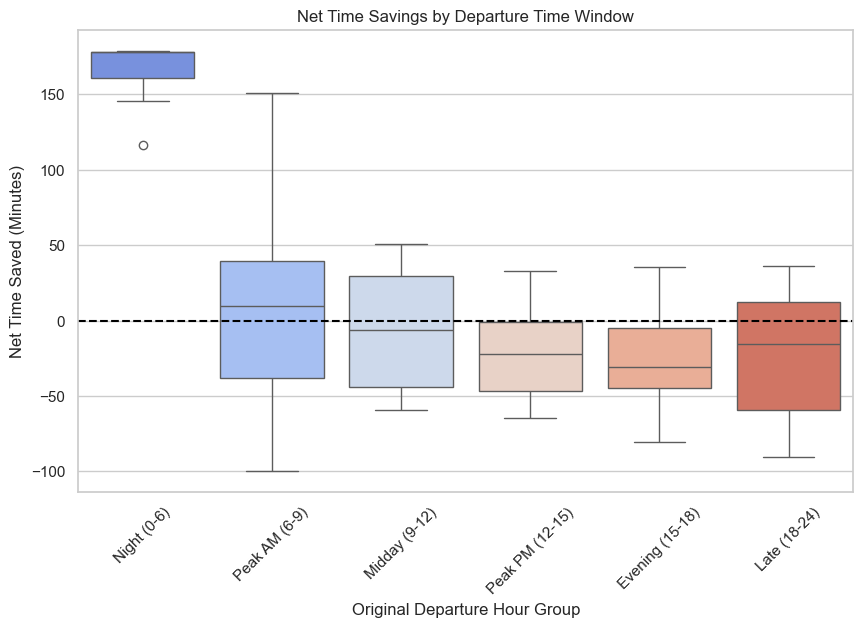

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Data prep
plot_data = optimization_results.copy()
plot_data['hour_bin'] = pd.cut(plot_data['original_hour'], 
                               bins=[0, 6, 9, 12, 15, 18, 24],
                               labels=['Night (0-6)', 'Peak AM (6-9)', 'Midday (9-12)',
                                      'Peak PM (12-15)', 'Evening (15-18)', 'Late (18-24)'])

plt.figure(figsize=(10, 6))
sns.boxplot(x='hour_bin', y='net_saving', data=plot_data, palette='coolwarm')

plt.axhline(0, color='black', linestyle='--')
plt.title("Net Time Savings by Departure Time Window")
plt.xlabel("Original Departure Hour Group")
plt.ylabel("Net Time Saved (Minutes)")
plt.xticks(rotation=45)
plt.show()

The 6-9AM window is where most of successful optimizations occur.

# Final Conclusion
We created a machine learning pipeline as part of our thorough research to minimize overall delays and optimize airplane departure timings.  The procedure started with advanced feature engineering, in which we used cyclical encoding to convert temporal information, such as the month and day of the week, into sine and cosine components in order to better represent their periodic nature.  One-hot encoding was used to analyze categorical information such as carrier, origin, destination, and tail number, producing a high-dimensional feature space with 4,180 columns.  An XGBoost regressor was our top-performing model; it was fine-tuned with ideal hyperparameters, such as a learning rate of 0.1, maximum depth of 5, and 200 estimators, and it demonstrated good prediction ability for flight delays.

Our investigation's main focus was on optimizing departure time using a number of specialized routines.  We first created a simple optimization method that experimented with moving departure schedules earlier in 1-hour increments. However, this showed surprising trends, since earlier departures occasionally strangely increased anticipated delays.  In order to balance the departure time change and delay reduction, we developed a more complex net time savings computation, which we defined as follows: Net Savings = (Hours Shifted Earlier × 60) - (New Delay - Original Delay).  While most other time slots either exhibited negligible benefits or negative consequences, we found through iterative testing that flights that were moved from 6 AM to 5 AM showed very large gains, with some attaining net time savings of over 170 minutes.

Starting with basic hour changes, our study advanced through several iterations of the optimization function before adding business logic limitations. The final design only permitted one-hour shifts for the promising 6 AM time slot and incorporated clever limits that prevented optimization attempts for evening flights (after 2 PM), where shifts regularly degraded performance.  We supplemented this with comprehensive diagnostic tools, such as a visualization tool to identify trends in the findings and a batch optimization analyzer that tested our method on hundreds of flights.  In order to identify areas that require model improvement, such as better representation of early morning flight characteristics and airport-specific constraints, we maintained strict evaluation metrics throughout the process, tracking both the anticipated improvements and (where available) actual operational results.

Key Notes:

- Due to time constraints of the project, we chose to continue with hyper parameter tuning for the XGBoost model. In a failed attempt to run hyper parameter tuning with the random forest regrssor, the code failed to complete within a day. this is a potential continuation to the project. 
- More data would be reqcuired with other third party values such as specific busiest hours classification, crew shifts, number of passengers, number of terminals, and more flights.

We thank you for reading through our codesheet. We hope you learned just as much as we did creating this project. 

# Extra Works Cited
- https://xgboost.readthedocs.io/en/latest/parameter.html
- https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html
- https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csr_matrix.html
- https://seaborn.pydata.org/examples/index.html
- https://plotly.com/python/
- https://www.kaggle.com/datasets/monareyhanii/flights?resource=download
- https://github.com/tidyverse/nycflights13/blob/main/data-raw/weather.csv
